In [579]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline

''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def feedback_func(So = 1360, Fo = 0, epsl0 = 0.5, a0 = 0, 
                  LW = 'Yang2014', SW = 'constant', TOA = 'Yang2014', overshoot = '1N2', cloud = 'effective',
                  p_guess=(250,250,200,200,200,20), output = 'default'):
    
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa
    R_star = 8.3145         # universal gas constant
    k1 = 0.2                # Fraction of heat transport to the nightside deposited in the boundary layer
    k2 = 5000               # Relates water vapor to the infrared opacity
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8         # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                # cloud emission temperature (FAT)
    kappa_SW = 5e-3 * 5       # shortwave opacity
    T_run = 270             # emission temperature for the runaway greenhouse

    ### Constants for water vapor calculations    
    RH1 = 0.9           # Dayside surface relative humidity
    RH2 = 0.8           # Dayside atmosphere relative humidity
    RH3 = 0.3           # Nightside atmosphere relative humidity
    es0 = 611.2         # reference pressure for CC relation
    M = 0.018           # molar mass of water vapor
    mm_dry = 0.028      # molar mass of dry air
    mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
    L = 2.501e6                 # latent heat of vaporization in J/kg
    To = 273.15                 # reference temperature for CC relation

    Cpd = 1005.7                # heat capacity of dry air in J/kg/K
    Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        
    def alpha(fc):
        alpha_p = 0.09 + fc - 0.09*fc
        return alpha_p
    
    def cld_frc(Fc):
        if cloud == 'no cloud':
            return 0
        elif cloud == 'fixed':
            return 0.3
        else:
            if Fc <= 0:                    # cloud fraction should always be positive
                fc = 0
            else:
                fc = k3 * np.log(Fc+1.0)     # expression of cloud fraction versus convection
                fc = min(fc, 1)            # fix the unrealistic case when we get cloud fraction larger than 1
            return fc

    def Tv(T, mass_ratio, w):               # virtual temperature, w is the water vapor mixing ratio
        return T * (1 + w/mass_ratio) / (1 + w)

    def sp(T, Pd, RH):
        if T > 100 and T < 400:
            es = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T)) # saturation vapor pressure
        else:
            es = 1e6
        qs = mass_ratio*es/(Pd + mass_ratio * es)     # sat. specific humidity, including additional vapor pressure
        q = RH * qs                                   # specific humidity
        return q, qs
    
    def a(T, q):
        if SW == 'constant':
            a = a0
        elif SW == 'feedback':
            if T > 100 and T < 400:
                e = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T)) # saturation vapor pressure
            else:
                e = 1e6
            k_SW = kappa_SW * (Pc + e) / g
#             k_SW = kappa_SW * (Pc) / g
            a = 1 - np.exp(-k_SW * q)
        return a

    def epsl(T, q):    # clear sky water vapor emissivity
        if LW == 'constant':
            epsl = epsl0
        elif LW == 'Yang2014':
            epsl = 1 - np.exp(-k2*q)  
        elif LW == 'feedback':
            if T > 100 and T < 400:
                e = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T)) # saturation vapor pressure
            else:
                e = 1e6
            kappa_LW = k2 * g / Pc
            k_LW = kappa_LW * (Pc + e) / g
            epsl = 1 - np.exp(-k_LW * q)
        return epsl
    
#     def OLR(Ts, Ta, emis):
#         if TOA == 'Yang2014':
#             OLR = (1 - emis) * sigma * Ts ** 4 + emis * sigma * Ta ** 4
#         elif TOA == 'runaway':
#             OLR = (1 - emis) * sigma * Ts ** 4 + emis * sigma * Ta ** 4
#             # you need to read a Transmission data (Ts0 and Trans0) first for this option!
#             Trans = np.interp(T, Ts0, Trans0)
#             OLR = Trans * OLR + (1-Trans) * sigma * T_run ** 4
#         return OLR

    def OLR(Ta, emis):
        OLR =  emis * sigma * Ta ** 4
        if TOA == 'Yang2014':
            return OLR
        else:      # you need to read a Transmission data (Ts0 and Trans0) first for this option!
            if overshoot == '0N2':
                Trans = np.interp(Ta, Ts0-30, Trans0)
                OLR = Trans * OLR + (1-Trans) * sigma * T_run ** 4
            elif overshoot == '0.1N2':
                Trans = np.interp(Ta, Ts0-15, Trans0)
                OLR = Trans * OLR + (1-Trans) * sigma * T_run ** 4
            else:
                Trans = np.interp(Ta, Ts0, Trans0)
                OLR = Trans * OLR + (1-Trans) * sigma * T_run ** 4
            if TOA == 'transition':
                return OLR
            elif TOA == 'runaway':
                if Ta > 850:
                    OLR = 5.67e-3*(Ta-850)**2 + sigma*T_run**4
                return OLR
    
    def check_MSE(T1, T2):
        q1, q1_s = sp(T1, Po, RH1)
        q2, q2_s = sp(T2, Pc, RH2)      
        Cp1 = Cpd*(1 - q1) + Cpv * q1  
        Cp2 = Cpd*(1 - q2) + Cpv * q2  
        Z_a = np.log(Po/Pc)*((R_star/mm_dry)*T2)/g       
        if Cp1*T1 + L*q1 - (Cp2*T2 + L*q2_s + g*Z_a) >= 0:  
            return 0     # convective atmosphere
        else:
            return 1     # stable atmosphere
        
    def equations(p):  # Define the equations to solve
        #print('solving or calculating ...')
        if solve_index == 0:             # RCE case
            T1, T2, T3, T4, Fa, Fc = p  
        elif solve_index == 1:           # RE case
            T1, T2, T3, T4, Fa = p
            Fc = 0
        
        # water vapor calculations for dayside surface
        q1, q1_s = sp(T1, Po, RH1)
        # water vapor calcaulations for dayside atmosphere
        q2, q2_s = sp(T2, Pc, RH2)
        # water vapor calculations for nightside atmosphere
        q3, q3_s = sp(T3, Pc, RH3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
#         if LW == 'constant':
#             epsl_2 = epsl0
#             epsl_3 = epsl0
#         elif LW == 'Yang2014':
#             epsl_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity 
#             epsl_3 = 1 - np.exp(-k2*q3)
#         elif LW == 'feedback':
#             epsl_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity 
#             epsl_3 = 1 - np.exp(-k2*q3)
        
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        H = ((R_star/mm_dry)*T2)/g  # scale height of dayside atmosphere* (needs double-check for steam atmos)
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs double-check for steam atmos)
        
        # dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha(cld_frc(Fc)))*(1-a(T2, q2)) - Fc - Fo + (1-cld_frc(Fc))*epsl(T2, q2)*sigma*T2**4 + cld_frc(Fc)*sigma*Tc**4 - sigma*T1**4

        # dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha(cld_frc(Fc)))*a(T2, q2) + Fc - Fa + (1-cld_frc(Fc))*epsl(T2, q2)*sigma*T1**4 + cld_frc(Fc)*sigma*T1**4 - (1-cld_frc(Fc))*(epsl(T2, q2)*sigma*T2**4 + OLR(T2, epsl(T2, q2))) - 2*cld_frc(Fc)*sigma*Tc**4
        
        Eq4 = Fa - Fd + epsl(T3, q3)*sigma*T4**4 - epsl(T3, q3)*sigma*T3**4 - OLR(T3, epsl(T3, q3))

        Eq5 = Fo + Fd + epsl(T3, q3)*sigma*T3**4 - sigma*T4**4
        
        Eq6 = T2 - T3      # weak temperature gradient assumption

        Eq7 = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature

        # calculation for other outputs
        epsl_2 = epsl(T2, q2)
        epsl_3 = epsl(T3, q3)
        Flux1 = (1/2)*So*(1-alpha(cld_frc(Fc)))*(1-a(T2, q2)) - Fc - Fo + (1-cld_frc(Fc))*epsl(T2, q2)*sigma*T2**4 + cld_frc(Fc)*sigma*Tc**4 - sigma*T1**4    # dayside surface LW emission into space
        Flux2 = (1/2)*So*(1-alpha(cld_frc(Fc)))*a(T2, q2) + Fc - Fa + (1-cld_frc(Fc))*epsl(T2, q2)*sigma*T1**4 + cld_frc(Fc)*sigma*T1**4 - (1-cld_frc(Fc))*(epsl(T2, q2)*sigma*T2**4 + OLR(T2, epsl(T2, q2))) - 2*cld_frc(Fc)*sigma*Tc**4
        Flux3 = Fa - Fd + epsl(T3, q3)*sigma*T4**4 - epsl(T3, q3)*sigma*T3**4 - OLR(T3, epsl(T3, q3))
        Flux4 = Fo + Fd + epsl(T3, q3)*sigma*T3**4 - sigma*T4**4                             
        
        fc = cld_frc(Fc)                           # cloud fraction
        alpha_p = alpha(cld_frc(Fc))               # planetary albedo 
        a_2 = a(T2, q2)                            # shortwave absorption coefficient
        alpha_b = (1-alpha(cld_frc(Fc)))*(1-a(T2, q2))   # Bond albedo? (assuming reflection is after absorption)
        FluxC = - (fc * (Flux1 + Flux2) - fc * sigma*Tc**4)    # net cloud radiative effect
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsl(T2, q2))*(1-fc)*sigma*T1**4 + (1-fc)*OLR(T2, epsl_2)
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsl(T3, q3))*sigma*T4**4 + OLR(T3,epsl_3)
        
        if output_index == 0:            
            if solve_index==0:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
            elif solve_index==1:
                return (Eq2, Eq3, Eq4, Eq5, Eq6)
        elif output_index==1:
            return(fc, q1, q2, q3, alpha_p, alpha_b, epsl_2, epsl_3, a_2, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4, FluxC)
        
    # Solve the equations using fsolve function
    output_index = 0
    
    # two-step calculations
    if p_guess[5] != 0:           # RCE case
        solve_index = 0
        (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
        if Fc <= 0:               # stable atmosphere, switch to RE
            solve_index = 1       
            new_p_guess = p_guess[:5]
            Fc = 0
            (T1, T2, T3, T4, Fa), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
            if check_MSE(T1, T2) == 0:   # convection is going to happen, either case does not work
                ier = 0             # no possible solution
                solve_index = 0     # switch back to RCE
    else:   # if RE, no convection
        solve_index = 1
        new_p_guess = p_guess[:5]
        Fc = 0
        (T1, T2, T3, T4, Fa), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
        if check_MSE(T1, T2) == 0:   # convection is going to happen, switch to RCE
            solve_index = 0
            (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
            if Fc <= 0:             # stable atmosphere, either case does not work
                ier = 0             # no possible solution
                Fc = 0
                solve_index = 1     # switch back to RE
    
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
#         Es = T1**4 + T4**4
#         Ea = T2**4 + T3**4 
#         print('The average atmosphere-surface energy ratio is:', (Ea/Es))
        print('\n')
    
    # Extract the additional terms
    output_index = 1
    if solve_index == 0:
        fc, q1, q2, q3, alpha_p, alpha_b, epsl_2, epsl_3, a_2, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4, FluxC = equations((T1, T2, T3, T4, Fa, Fc))
    elif solve_index == 1:
        fc, q1, q2, q3, alpha_p, alpha_b, epsl_2, epsl_3, a_2, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4, FluxC = equations((T1, T2, T3, T4, Fa))
    
    outputs = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4, 'Fa': Fa, 'Fc': Fc, 'fc': fc,
               'q1': q1, 'q2': q2, 'q3': q3, 'alpha_p': alpha_p, 'alpha_b': alpha_b, 'epsl_2': epsl_2,
               'epsl_3': epsl_3, 'a_2': a_2, 'OLR_day': OLR_day, 'OLR_night': OLR_night,
               'Flux1': Flux1, 'Flux2': Flux2, 'Flux3': Flux3, 'Flux4': Flux4, 'FluxC': FluxC,
               'info': info, 'ier': ier, 'msg': msg}
    
    if output == 'debug':
        return T1, T2, T3, T4, Fa, Fc, fc, q1, q2, q3, alpha_p, alpha_b, epsl_2, epsl_3, a_2, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4, FluxC, info, ier, msg
    else:
        return outputs

In [580]:
## A test run
# load the transmission data from Koll and Cronin 2018
trans_data = pd.read_csv('./screenshots/Chaverot2021_data/Ts-Trans.csv', header=None)
# assign headers
trans_data.columns = ["Ts", "Trans"]
# make data in right order (necessary for interpolation)
trans_data = trans_data.sort_values(by=['Ts'], ascending=True)
# interpolate data to a consistent temperature coordinate
Trans0 = trans_data['Trans']; Ts0 = trans_data['Ts'];

# Example debug mode
S = 2000       # W/m2
T1_init = 328  # K
T2_init = 314  # K
T3_init = 314  # K
T4_init = 279  # K
Fa_init = 378  # W/m2
Fc_init = 318  # W/m2

output = feedback_func(So=S, epsl0 = 0.1, a0 = 0, \
                       LW = 'constant', SW = 'constant', TOA = 'runaway', overshoot = '0N2', \
                       p_guess = (T1_init, T2_init, T3_init, T4_init, Fa_init, Fc_init),\
                       output = 'debug')

print(output)

We have a solution:  (265.5119937100793, 234.2666973593584, 234.2666973593584, 178.58631614000424, 202.97945180322955, 295.40588198603393)


(265.5119937100793, 234.2666973593584, 234.2666973593584, 178.58631614000424, 202.97945180322955, 295.40588198603393, 0.45533837903857816, 0.0019752408498031862, 0.00019511179658154984, 7.316692371808118e-05, 0.5043579249251061, 0.4956420750748939, 0.1, 0.1, 0, 292.6626232994132, 202.9794518026966, -4.9671257329464424e-08, 2.1922431869825232e-08, -1.1328893378959037e-10, 6.462741453105991e-10, 72.2484709479143, {'nfev': 154, 'fjac': array([[-2.96236071e-03,  1.51031486e-03, -8.36689138e-08,
         5.66604766e-07,  1.81829955e-12,  9.99994472e-01],
       [ 9.60931502e-01, -2.94620786e-02,  6.73455942e-05,
        -4.56104694e-04, -2.75198224e-01,  2.89113899e-03],
       [-7.82121593e-02,  2.39797788e-03, -9.54750216e-01,
         8.60129328e-02, -2.73735004e-01, -2.35444248e-04],
       [-1.48101672e-02,  4.54078892e-04, -7.41308371e-02,
      

In [581]:
## Sweep over the parameter space with a cold start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 34*2+1)  # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
# so = np.flip(so)

# Create an empty list to store the output
cold_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8

for idx, s in enumerate(so):
    print(idx, s)
    
    output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, \
                           LW = 'feedback', SW = 'feedback', TOA = 'runaway', \
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the cold branch, switch to hot branch instead \n")
        
        T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
        initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
        
        output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                               LW = 'feedback', SW = 'feedback', TOA = 'runaway', 
                               p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the hot branch \n")
            initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
            cold_list.append(nan_dict)
        else:      # successful for hot branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            cold_list.append(output)
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for cold branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        cold_list.append(output)
        
so_cold = so

0 800.0
We have a solution:  (238.39816941118545, 207.05832741532083, 207.05832741532083, 114.03987025502761, 38.88035009410006, 106.73392117031982)


1 829.4117647058823
We have a solution:  (240.0850235706506, 208.59438788543403, 208.59438788543403, 117.37592639119752, 42.507428604066504, 109.99601390181262)


2 858.8235294117648
We have a solution:  (241.72932088175676, 210.10253811953666, 210.10253811953666, 120.7418211334636, 46.26760691943638, 113.34244086393298)


3 888.2352941176471
We have a solution:  (243.32891321934432, 211.58127001826242, 211.58127001826242, 124.15381024846216, 50.17924734420205, 116.7971923690197)


4 917.6470588235294
We have a solution:  (244.84626613497602, 212.99580818910576, 212.99580818910576, 127.5852728830796, 54.26726496655158, 120.46069163054754)


5 947.0588235294117
We have a solution:  (246.27527339410287, 214.33970183759064, 214.33970183759064, 131.0180032200693, 58.535911948163374, 124.3555127444475)


6 976.4705882352941
We have a solution

In [582]:
# extract all T1 values from output_list
T1_cold = np.array([d['T1'] for d in cold_list])

T2_cold = np.array([d['T2'] for d in cold_list])

T3_cold = np.array([d['T3'] for d in cold_list])

T4_cold = np.array([d['T4'] for d in cold_list])

Fa_cold = np.array([d['Fa'] for d in cold_list])

Fc_cold = np.array([d['Fc'] for d in cold_list])

fc_cold = np.array([d['fc'] for d in cold_list])

ap_cold = np.array([d['alpha_p'] for d in cold_list])

ab_cold = np.array([d['alpha_b'] for d in cold_list])

OLR_cold_day = np.array([d['OLR_day'] for d in cold_list])

OLR_cold_night = np.array([d['OLR_night'] for d in cold_list])

e2_cold = np.array([d['epsl_2'] for d in cold_list])

a2_cold = np.array([d['a_2'] for d in cold_list])

F1_cold = np.array([d['Flux1'] for d in cold_list])

F2_cold = np.array([d['Flux2'] for d in cold_list])

F3_cold = np.array([d['Flux3'] for d in cold_list])

F4_cold = np.array([d['Flux4'] for d in cold_list])


In [583]:
## Sweep over the parameter space with a hot start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 34*2+1)  # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
hot_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess_temp = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8
T_test = abs(((max(so)/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

for idx, s in enumerate(so):
    print(idx, s)
#     T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
#     initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
    output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'feedback', TOA = 'runaway', 
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the hot branch, switch to cold branch instead \n")
        initial_guess = initial_guess_temp
        
        output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                               LW = 'Yang2014', SW = 'feedback', TOA = 'runaway', 
                               p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the cold branch \n")
            initial_guess = (280,250,250,220,200,100)
            hot_list.append(nan_dict)
        else:      # successful for cold branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            hot_list.append(output)               
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for hot branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        hot_list.append(output)
        
so_hot = so

0 2800.0
We have a solution:  (1093.3137463974238, 1093.3137463974238, 1093.3137463974238, 1093.7433175269189, 637.0000000000038, 0)


1 2770.5882352941176
We have a solution:  (1090.8764773531198, 1090.8764773531198, 1090.8764773531198, 1091.304392904163, 630.3088235294066, 0)


2 2741.176470588235
We have a solution:  (1088.4142941850398, 1088.4142941850398, 1088.4142941850398, 1088.840547252432, 623.6176470588194, 0)


3 2711.764705882353
We have a solution:  (1085.926416497716, 1085.926416497716, 1085.926416497716, 1086.3510013133216, 616.9264705882377, 0)


4 2682.3529411764703
We have a solution:  (1083.4120226791147, 1083.4120226791147, 1083.4120226791147, 1083.8349337293992, 610.2352941176401, 0)


5 2652.9411764705883
We have a solution:  (1080.8702463741427, 1080.8702463741427, 1080.8702463741427, 1081.291478428575, 603.5441176470649, 0)


6 2623.529411764706
We have a solution:  (1078.3001729972164, 1078.3001729972164, 1078.3001729972164, 1078.7197211395844, 596.852941176467

We have a solution:  (244.84630298429778, 212.99584269326414, 212.99584269326414, 127.58486540609047, 54.26704161104545, 120.4604083386305)


65 888.2352941176471
We have a solution:  (243.32894229248524, 211.58129700685458, 211.58129700685458, 124.15343334957304, 50.17908577652095, 116.79698331598026)


66 858.8235294117648
We have a solution:  (241.7293416103876, 210.10255720627333, 210.10255720627333, 120.74154452481419, 46.26749390832984, 113.34229365452745)


67 829.4117647058823
We have a solution:  (240.08503819915498, 208.59440125345424, 208.59440125345424, 117.3757134395251, 42.50735076539024, 109.99591177046364)


68 800.0
We have a solution:  (238.3981794798668, 207.05833655288893, 207.05833655288893, 114.0397288054346, 38.88029751772486, 106.73385165818824)




In [584]:
# extract all T1 values from output_list
T1_hot = np.array([d['T1'] for d in hot_list])

T2_hot = np.array([d['T2'] for d in hot_list])

T3_hot = np.array([d['T3'] for d in hot_list])

T4_hot = np.array([d['T4'] for d in hot_list])

Fa_hot = np.array([d['Fa'] for d in hot_list])

Fc_hot = np.array([d['Fc'] for d in hot_list])

fc_hot = np.array([d['fc'] for d in hot_list])

ap_hot = np.array([d['alpha_p'] for d in hot_list])

ab_hot = np.array([d['alpha_b'] for d in hot_list])

OLR_hot_day = np.array([d['OLR_day'] for d in hot_list])

OLR_hot_night = np.array([d['OLR_night'] for d in hot_list])

e2_hot = np.array([d['epsl_2'] for d in hot_list])

a2_hot = np.array([d['a_2'] for d in hot_list])

F1_hot = np.array([d['Flux1'] for d in hot_list])

F2_hot = np.array([d['Flux2'] for d in hot_list])

F3_hot = np.array([d['Flux3'] for d in hot_list])

F4_hot = np.array([d['Flux4'] for d in hot_list])


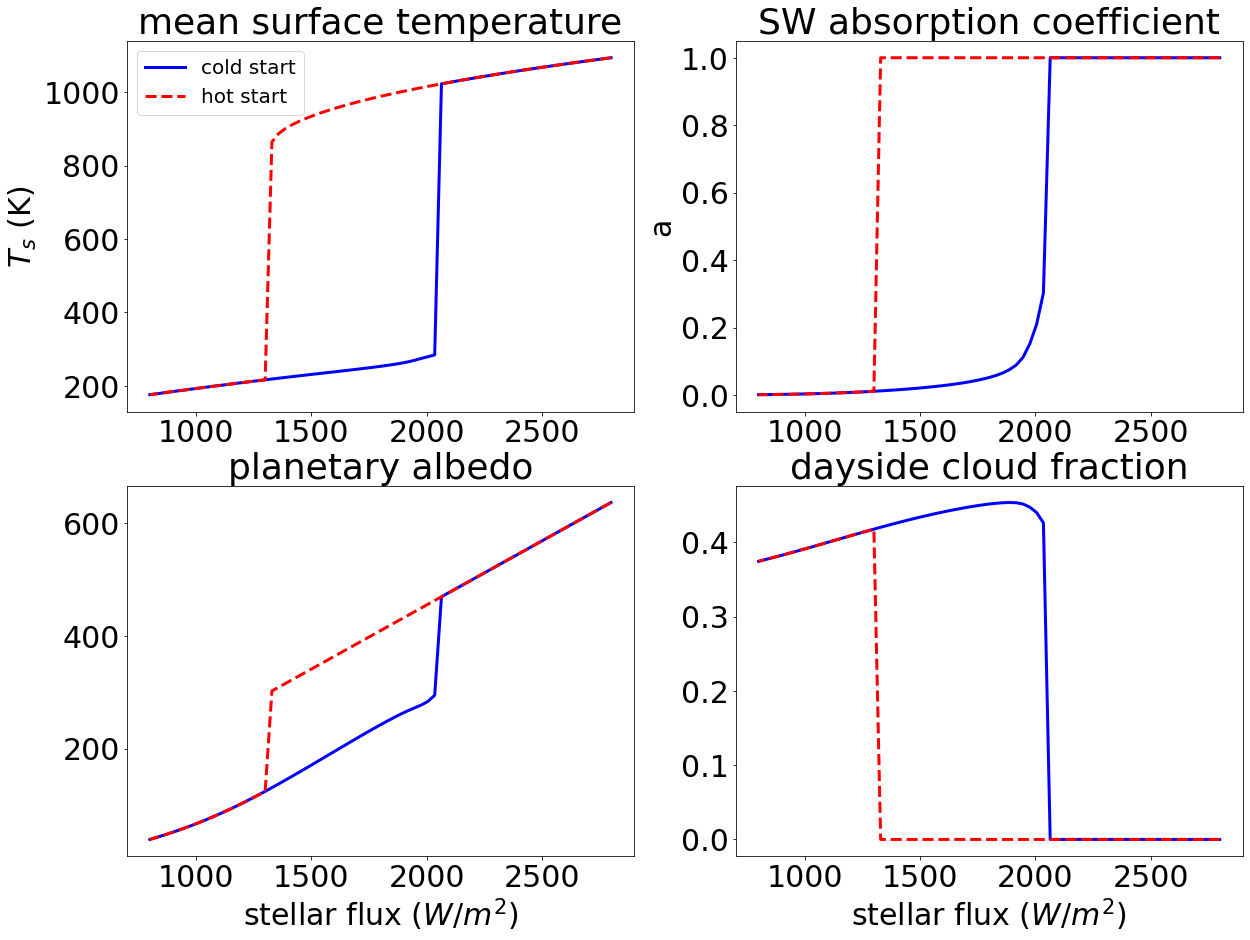

In [585]:
# print(T1_hot)
# check the results with a cold start
def plot_abs(xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(20,15)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so_cold, (T1_cold+T4_cold)/2, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax[0,0].plot(so_hot, (T1_hot+T4_hot)/2, '--', color = 'red', linewidth=3, label = r'hot start')
    ax[0,0].set_ylabel(r'$T_s$ (K)')
#     ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title(r'mean surface temperature')
    ax[0,0].legend(loc = 'upper left',fontsize=20,)
    
    ax[0,1].plot(so_cold, a2_cold, '-', color = 'blue',linewidth=3)
    ax[0,1].plot(so_hot, a2_hot, '--', color = 'red', linewidth=3)
    ax[0,1].set_ylabel(r'a')
#     ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].set_title(r'SW absorption coefficient')
#     ax[0,1].legend()
    
    ax[1,0].plot(so_cold, (OLR_cold_night),'-', color = 'blue',linewidth=3)
    ax[1,0].plot(so_hot, (OLR_hot_night),'--',color = 'red',linewidth=3)
#     ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_title('planetary albedo')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,0].legend()
    
#     # Dayside energy budgets
    ax[1,1].plot(so_cold, fc_cold,'-', color = 'blue',linewidth=3)
    ax[1,1].plot(so_hot, fc_hot,'--', color = 'red',linewidth=3)
#     ax[1,1].plot(so_cold, F3_cold,'-', color = 'red',linewidth=3, label = r'$F_{3}$')
#     ax[1,1].plot(so_cold, Fc_cold,':', color = 'red',linewidth=3, label = r'$F_{c}$')
#     ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_title('dayside cloud fraction')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,1].set_ylabel(r'$W/m^2$')
#     ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()
# print(min(OLR_cold_day - np.flip(OLR_hot_day)))

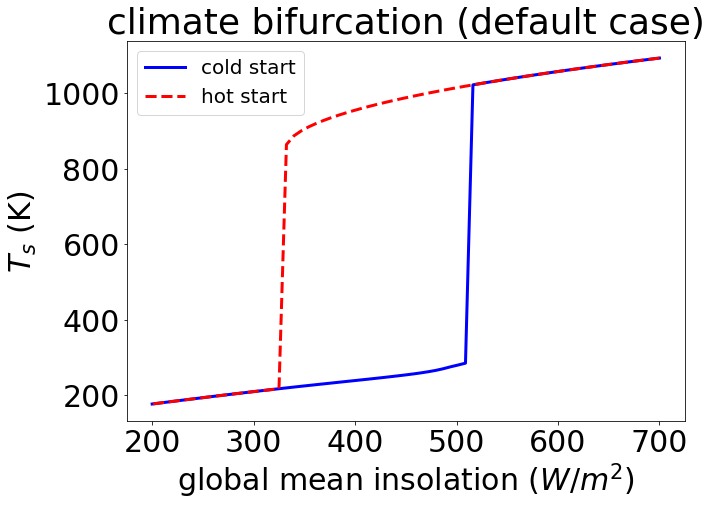

In [586]:
# print(T1_hot)
# check the results with a cold start
def plot_abs(xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(figsize=(10,7)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax.plot(so_cold/4, (T1_cold+T4_cold)/2, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax.plot(so_hot/4, (T1_hot+T4_hot)/2, '--', color = 'red', linewidth=3, label = r'hot start')
    ax.set_ylabel(r'$T_s$ (K)')
    ax.set_xlabel(r'global mean insolation ($W/m^2$)')
    ax.set_title(r'climate bifurcation (default case)')
    ax.legend(loc = 'upper left',fontsize=20,)
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()
# print(min(OLR_cold_day - np.flip(OLR_hot_day)))

In [605]:
## Fixed kappa_SW experiement: sweep over the parameter space with a cold start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 17*2+1)  # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
# so = np.flip(so)

# Create an empty list to store the output
cold_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8

for idx, s in enumerate(so):
    print(idx, s)
    
    output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, \
                           LW = 'Yang2014', SW = 'constant', TOA = 'runaway',
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the cold branch, switch to hot branch instead \n")
        
        T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
        initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
        
        output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                               LW = 'Yang2014', SW = 'constant', TOA = 'runaway',
                               p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the hot branch \n")
            initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
            cold_list.append(nan_dict)
        else:      # successful for hot branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            cold_list.append(output)
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for cold branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        cold_list.append(output)
        
so_cold = so

# extract all T1 values from output_list
T1_cold_r = np.array([d['T1'] for d in cold_list])

T2_cold = np.array([d['T2'] for d in cold_list])

T3_cold = np.array([d['T3'] for d in cold_list])

T4_cold_r = np.array([d['T4'] for d in cold_list])

# Fa_cold = np.array([d['Fa'] for d in cold_list])

Fc_cold_r = np.array([d['Fc'] for d in cold_list])

fc_cold_r = np.array([d['fc'] for d in cold_list])

ap_cold_r = np.array([d['alpha_p'] for d in cold_list])

# ab_cold = np.array([d['alpha_b'] for d in cold_list])

OLR_cold_day_r = np.array([d['OLR_day'] for d in cold_list])

OLR_cold_night_r = np.array([d['OLR_night'] for d in cold_list])

# e2_cold = np.array([d['epsl_2'] for d in cold_list])

# a2_cold = np.array([d['a_2'] for d in cold_list])

# F1_cold = np.array([d['Flux1'] for d in cold_list])

# F2_cold = np.array([d['Flux2'] for d in cold_list])

# F3_cold = np.array([d['Flux3'] for d in cold_list])

# F4_cold = np.array([d['Flux4'] for d in cold_list])


0 800.0
We have a solution:  (238.38610088120475, 207.04737505636157, 207.04737505636157, 114.01620857377019, 38.855071146843805, 106.96380959744292)


1 858.8235294117648
We have a solution:  (241.7119220036423, 210.08651913209079, 210.08651913209079, 120.70521465465157, 46.22635391841036, 113.692548572839)


2 917.6470588235294
We have a solution:  (244.82339415644964, 212.9743940906311, 212.9743940906311, 127.531014346003, 54.200973754606096, 120.97298182213233)


3 976.4705882352941
We have a solution:  (247.6317862348549, 215.62702102464186, 215.62702102464186, 134.41867472013277, 62.88222385898055, 129.1160491595521)


4 1035.2941176470588
We have a solution:  (250.2676243051573, 218.1649028342514, 218.1649028342514, 141.48454162656162, 72.30833363024948, 137.94313062909168)


5 1094.1176470588234
We have a solution:  (252.63500199186453, 220.49144983982498, 220.49144983982498, 148.51033821901657, 82.47080271369938, 147.67762170455714)


6 1152.9411764705883
We have a solution:  

In [606]:
## Fixed kappa_SW experiment: Sweep over the parameter space with a hot start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 17*2+1)  # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
hot_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess_temp = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8
T_test = abs(((max(so)/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

for idx, s in enumerate(so):
    print(idx, s)
#     T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
#     initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
    output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'constant', TOA = 'runaway', 
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the hot branch, switch to cold branch instead \n")
        initial_guess = initial_guess_temp
        
        output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                               LW = 'Yang2014', SW = 'constant', TOA = 'runaway', 
                               p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the cold branch \n")
            initial_guess = (280,250,250,220,200,100)
            hot_list.append(nan_dict)
        else:      # successful for cold branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            hot_list.append(output)               
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for hot branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        hot_list.append(output)
        
so_hot = so

# extract all T1 values from output_list
T1_hot_r = np.array([d['T1'] for d in hot_list])

T2_hot = np.array([d['T2'] for d in hot_list])

T3_hot = np.array([d['T3'] for d in hot_list])

T4_hot_r = np.array([d['T4'] for d in hot_list])

# Fa_hot = np.array([d['Fa'] for d in hot_list])

Fc_hot_r = np.array([d['Fc'] for d in hot_list])

fc_hot_r = np.array([d['fc'] for d in hot_list])

ap_hot_r = np.array([d['alpha_p'] for d in hot_list])

# ab_hot = np.array([d['alpha_b'] for d in hot_list])

OLR_hot_day_r = np.array([d['OLR_day'] for d in hot_list])

OLR_hot_night_r = np.array([d['OLR_night'] for d in hot_list])

# e2_hot = np.array([d['epsl_2'] for d in hot_list])

# a2_hot = np.array([d['a_2'] for d in hot_list])

# F1_hot = np.array([d['Flux1'] for d in hot_list])

# F2_hot = np.array([d['Flux2'] for d in hot_list])

# F3_hot = np.array([d['Flux3'] for d in hot_list])

# F4_hot = np.array([d['Flux4'] for d in hot_list])


0 2800.0
We have a solution:  (1097.5868816345728, 1093.3137460476792, 1093.3137460476792, 1093.743318068645, 636.9999999999985, 0)


1 2741.176470588235
We have a solution:  (1092.6544869708841, 1088.4142941852563, 1088.4142941852563, 1088.8405472525983, 623.6176470588183, 0)


2 2682.3529411764703
We have a solution:  (1087.6190420409366, 1083.412022679382, 1083.412022679382, 1083.8349337296056, 610.2352941176439, 0)


3 2623.529411764706
We have a solution:  (1082.4738095238401, 1078.300172997549, 1078.300172997549, 1078.7197211398432, 596.852941176464, 0)


4 2564.705882352941
We have a solution:  (1077.211282527991, 1073.0712120605133, 1073.0712120605133, 1073.4873790638205, 583.4705882352973, 0)


5 2505.8823529411766
We have a solution:  (1071.8230554043012, 1067.716701953692, 1067.716701953692, 1068.1294728619293, 570.0882352941271, 0)


6 2447.0588235294117
We have a solution:  (1066.29966524871, 1062.2271400388, 1062.2271400388, 1062.6365039267987, 556.7058823529491, 0)


7 2

In [599]:
## Fixed kappa_SW experiement: sweep over the parameter space with a cold start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 17*2+1)  # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
# so = np.flip(so)

# Create an empty list to store the output
cold_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8

for idx, s in enumerate(so):
    print(idx, s)
    
    output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, \
                           LW = 'Yang2014', SW = 'feedback', TOA = 'Yang2014',  \
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the cold branch, switch to hot branch instead \n")
        
        T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
        initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
        
        output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                               LW = 'Yang2014', SW = 'feedback', TOA = 'Yang2014', 
                               p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the hot branch \n")
            initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
            cold_list.append(nan_dict)
        else:      # successful for hot branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            cold_list.append(output)
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for cold branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        cold_list.append(output)
        
so_cold = so

# extract all T1 values from output_list
T1_cold_sw = np.array([d['T1'] for d in cold_list])

T2_cold = np.array([d['T2'] for d in cold_list])

T3_cold = np.array([d['T3'] for d in cold_list])

T4_cold_sw = np.array([d['T4'] for d in cold_list])

# Fa_cold = np.array([d['Fa'] for d in cold_list])

Fc_cold_sw = np.array([d['Fc'] for d in cold_list])

fc_cold_sw = np.array([d['fc'] for d in cold_list])

ap_cold_sw = np.array([d['alpha_p'] for d in cold_list])

# ab_cold = np.array([d['alpha_b'] for d in cold_list])

# OLR_cold_day = np.array([d['OLR_day'] for d in cold_list])

# OLR_cold_night = np.array([d['OLR_night'] for d in cold_list])

# e2_cold = np.array([d['epsl_2'] for d in cold_list])

# a2_cold = np.array([d['a_2'] for d in cold_list])

# F1_cold = np.array([d['Flux1'] for d in cold_list])

# F2_cold = np.array([d['Flux2'] for d in cold_list])

# F3_cold = np.array([d['Flux3'] for d in cold_list])

# F4_cold = np.array([d['Flux4'] for d in cold_list])

## Fixed kappa_SW experiment: Sweep over the parameter space with a hot start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 17*2+1)  # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
hot_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess_temp = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8
T_test = abs(((max(so)/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

for idx, s in enumerate(so):
    print(idx, s)
#     T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
#     initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
    output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'feedback', TOA = 'Yang2014', 
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the hot branch, switch to cold branch instead \n")
        initial_guess = initial_guess_temp
        
        output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                               LW = 'Yang2014', SW = 'feedback', TOA = 'Yang2014',  
                               p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the cold branch \n")
            initial_guess = (280,250,250,220,200,100)
            hot_list.append(nan_dict)
        else:      # successful for cold branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            hot_list.append(output)               
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for hot branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        hot_list.append(output)
        
so_hot = so

# extract all T1 values from output_list
T1_hot_sw = np.array([d['T1'] for d in hot_list])

T2_hot = np.array([d['T2'] for d in hot_list])

T3_hot = np.array([d['T3'] for d in hot_list])

T4_hot_sw = np.array([d['T4'] for d in hot_list])

# Fa_hot = np.array([d['Fa'] for d in hot_list])

Fc_hot_sw = np.array([d['Fc'] for d in hot_list])

fc_hot_sw = np.array([d['fc'] for d in hot_list])

ap_hot_sw = np.array([d['alpha_p'] for d in hot_list])

# ab_hot = np.array([d['alpha_b'] for d in hot_list])

# OLR_hot_day = np.array([d['OLR_day'] for d in hot_list])

# OLR_hot_night = np.array([d['OLR_night'] for d in hot_list])

# e2_hot = np.array([d['epsl_2'] for d in hot_list])

# a2_hot = np.array([d['a_2'] for d in hot_list])

# F1_hot = np.array([d['Flux1'] for d in hot_list])

# F2_hot = np.array([d['Flux2'] for d in hot_list])

# F3_hot = np.array([d['Flux3'] for d in hot_list])

# F4_hot = np.array([d['Flux4'] for d in hot_list])


0 800.0
We have a solution:  (256.9293577861052, 224.8496733761278, 224.8496733761278, 148.16072176652415, 42.58256110905833, 73.56799277398018)


1 858.8235294117648
We have a solution:  (259.3435195909645, 227.39255231352902, 227.39255231352902, 159.08321800053426, 55.49043992378959, 86.11387045889308)


2 917.6470588235294
We have a solution:  (261.39461328042404, 229.6140798734804, 229.6140798734804, 168.80653643376777, 68.87988657977563, 99.35553871151451)


3 976.4705882352941
We have a solution:  (263.1849973701737, 231.60381829751597, 231.60381829751597, 177.59466221744464, 82.50924143193315, 112.93408219696693)


4 1035.2941176470588
We have a solution:  (264.7846569909142, 233.42464873465167, 233.42464873465167, 185.64713532965362, 96.20974588372778, 126.59639545989819)


5 1094.1176470588234
We have a solution:  (266.24368296083054, 235.12302182256687, 235.12302182256687, 193.11828001801558, 109.863129144179, 140.15560545225472)


6 1152.9411764705883
We have a solution:  (2

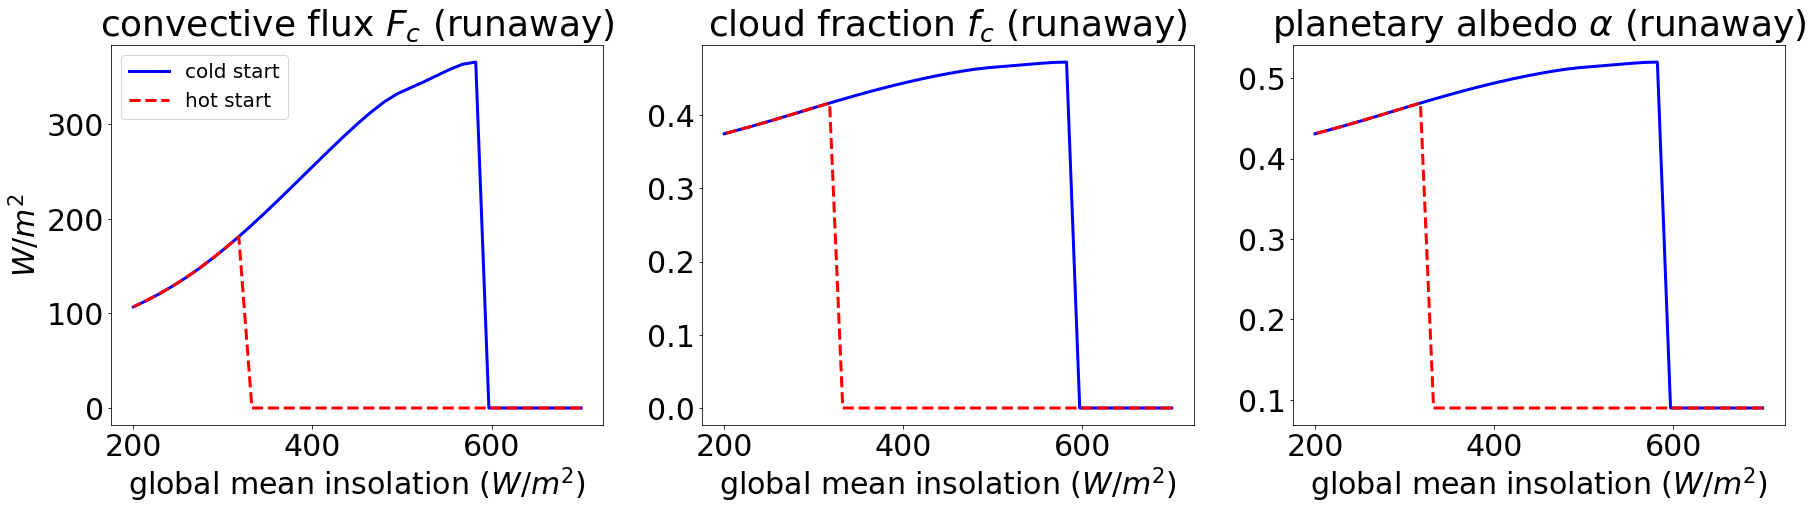

In [608]:
# print(T1_hot)
# check the results with a cold start
def plot_abs(xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(1, 3, figsize=(30,7)) 
    plt.rc('font', size = 30) 
    
#     # Dayside temperature structure
#     ax[0].plot(so_cold/4, (Fc_cold_sw), '-', color = 'blue',linewidth=3, label = r'cold start')
#     ax[0].plot(so_hot/4, (Fc_hot_sw), '--', color = 'red', linewidth=3, label = r'hot start')
#     ax[0].set_ylabel(r'$W/m^2$')
#     ax[0].set_xlabel(r'global mean insolation ($W/m^2$)')
#     ax[0].set_title(r'convective flux $F_c$ (SW abs.)')
#     ax[0].legend(loc = 'upper left',fontsize=20,)
    
#     ax[1].plot(so_cold/4, (fc_cold_sw), '-', color = 'blue',linewidth=3)
#     ax[1].plot(so_hot/4, (fc_hot_sw), '--', color = 'red', linewidth=3)
# #     ax[1].set_ylabel(r'$T_s$ (K)')
#     ax[1].set_xlabel(r'global mean insolation ($W/m^2$)')
#     ax[1].set_title(r'cloud fraction $f_c$ (SW abs.)')
    
#     ax[2].plot(so_cold/4, (ap_cold_sw), '-', color = 'blue',linewidth=3)
#     ax[2].plot(so_hot/4, (ap_hot_sw), '--', color = 'red', linewidth=3)
# #     ax[2].set_ylabel(r'$T_s$ (K)')
#     ax[2].set_xlabel(r'global mean insolation ($W/m^2$)')
#     ax[2].set_title(r'planetary albedo $\alpha$ (SW abs.)')

    
    # Dayside temperature structure
    ax[0].plot(so_cold/4, (Fc_cold_r), '-', color = 'blue',linewidth=3, label = r'cold start')
    ax[0].plot(so_hot/4, (Fc_hot_r), '--', color = 'red', linewidth=3, label = r'hot start')
    ax[0].set_ylabel(r'$W/m^2$')
    ax[0].set_xlabel(r'global mean insolation ($W/m^2$)')
    ax[0].set_title(r'convective flux $F_c$ (runaway)')
    ax[0].legend(loc = 'upper left',fontsize=20,)
    
    ax[1].plot(so_cold/4, (fc_cold_r), '-', color = 'blue',linewidth=3)
    ax[1].plot(so_hot/4, (fc_hot_r), '--', color = 'red', linewidth=3)
#     ax[1].set_ylabel(r'$T_s$ (K)')
    ax[1].set_xlabel(r'global mean insolation ($W/m^2$)')
    ax[1].set_title(r'cloud fraction $f_c$ (runaway)')
    
    ax[2].plot(so_cold/4, (ap_cold_r), '-', color = 'blue',linewidth=3)
    ax[2].plot(so_hot/4, (ap_hot_r), '--', color = 'red', linewidth=3)
#     ax[2].set_ylabel(r'$T_s$ (K)')
    ax[2].set_xlabel(r'global mean insolation ($W/m^2$)')
    ax[2].set_title(r'planetary albedo $\alpha$ (runaway)')
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()

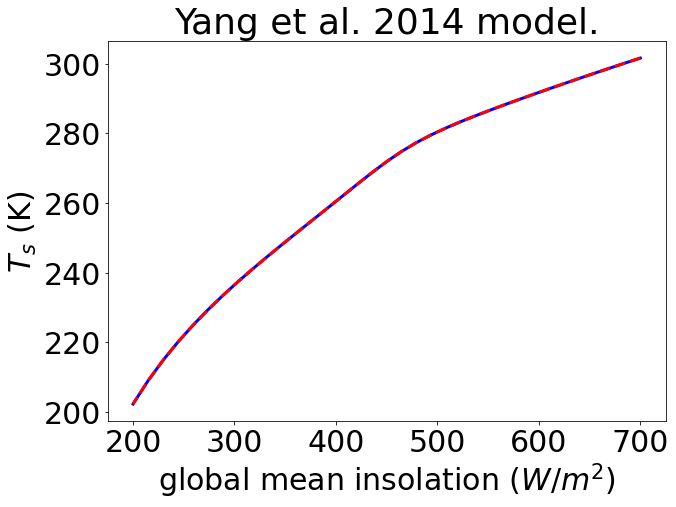

In [570]:
# print(T1_hot)
# check the results with a cold start
def plot_abs(xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots( figsize=(10,7)) 
    plt.rc('font', size = 30) 
    
#     # Dayside temperature structure
#     ax[0].plot(so_cold/4, (T1_cold_r+T4_cold_r)/2, '-', color = 'blue',linewidth=3, label = r'cold start')
#     ax[0].plot(so_hot/4, (T1_hot_r+T4_hot_r)/2, '--', color = 'red', linewidth=3, label = r'hot start')
#     ax[0].set_ylabel(r'$T_s$ (K)')
#     ax[0].set_xlabel(r'global mean insolation ($W/m^2$)')
#     ax[0].set_title(r'Yang et al. 2014 + runaway GH')
#     ax[0].legend(loc = 'upper left',fontsize=20,)
    
    ax.plot(so_cold/4, (T1_cold_sw+T4_cold_sw)/2, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax.plot(so_hot/4, (T1_hot_sw+T4_hot_sw)/2, '--', color = 'red', linewidth=3, label = r'hot start')
#     ax[1].set_ylabel(r'T_s (K)')
    ax.set_ylabel(r'$T_s$ (K)')
    ax.set_xlabel(r'global mean insolation ($W/m^2$)')
    ax.set_title(r'Yang et al. 2014 model.')
#     ax[1].legend()
    
#     ax[1,0].plot(so_cold, ap_cold,'-', color = 'blue',linewidth=3)
#     ax[1,0].plot(so_hot, ap_hot,'--',color = 'red',linewidth=3)
# #     ax[1,0].set_xlim([1000, 2500])
#     ax[1,0].set_title('planetary albedo')
#     ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
# #     ax[1,0].legend()
    
# #     # Dayside energy budgets
#     ax[1,1].plot(so_cold, fc_cold,'-', color = 'blue',linewidth=3)
#     ax[1,1].plot(so_hot, fc_hot,'--', color = 'red',linewidth=3)
# #     ax[1,1].plot(so_cold, F3_cold,'-', color = 'red',linewidth=3, label = r'$F_{3}$')
# #     ax[1,1].plot(so_cold, Fc_cold,':', color = 'red',linewidth=3, label = r'$F_{c}$')
# #     ax[1,1].set_xlim([1000, 2500])
#     ax[1,1].set_title('dayside cloud fraction')
#     ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
# #     ax[1,1].set_ylabel(r'$W/m^2$')
# #     ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()

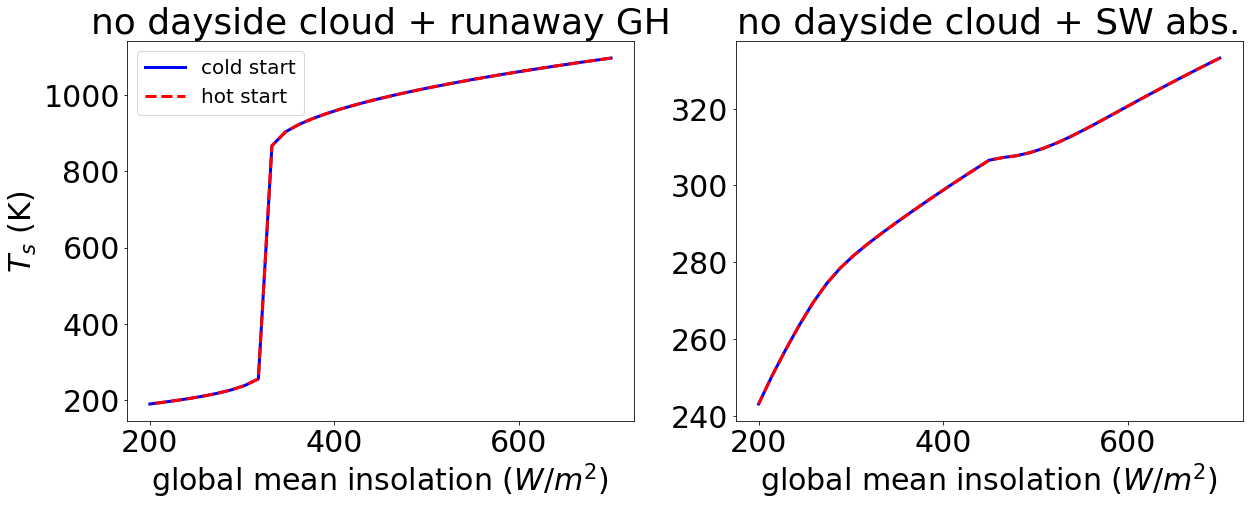

In [592]:
# print(T1_hot)
# check the results with a cold start
def plot_abs(xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(1, 2, figsize=(20,7)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0].plot(so_cold/4, (T1_cold_r+T4_cold_r)/2, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax[0].plot(so_hot/4, (T1_hot_r+T4_hot_r)/2, '--', color = 'red', linewidth=3, label = r'hot start')
    ax[0].set_ylabel(r'$T_s$ (K)')
    ax[0].set_xlabel(r'global mean insolation ($W/m^2$)')
    ax[0].set_title(r'no dayside cloud + runaway GH')
    ax[0].legend(loc = 'upper left',fontsize=20,)
    
    ax[1].plot(so_cold/4, (T1_cold_sw+T4_cold_sw)/2, '-', color = 'blue',linewidth=3)
    ax[1].plot(so_hot/4, (T1_hot_sw+T4_hot_sw)/2, '--', color = 'red', linewidth=3)
#     ax[1].set_ylabel(r'T_s (K)')
    ax[1].set_xlabel(r'global mean insolation ($W/m^2$)')
    ax[1].set_title(r'no dayside cloud + SW abs.')
#     ax[1].legend()
    
#     ax[1,0].plot(so_cold, ap_cold,'-', color = 'blue',linewidth=3)
#     ax[1,0].plot(so_hot, ap_hot,'--',color = 'red',linewidth=3)
# #     ax[1,0].set_xlim([1000, 2500])
#     ax[1,0].set_title('planetary albedo')
#     ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
# #     ax[1,0].legend()
    
# #     # Dayside energy budgets
#     ax[1,1].plot(so_cold, fc_cold,'-', color = 'blue',linewidth=3)
#     ax[1,1].plot(so_hot, fc_hot,'--', color = 'red',linewidth=3)
# #     ax[1,1].plot(so_cold, F3_cold,'-', color = 'red',linewidth=3, label = r'$F_{3}$')
# #     ax[1,1].plot(so_cold, Fc_cold,':', color = 'red',linewidth=3, label = r'$F_{c}$')
# #     ax[1,1].set_xlim([1000, 2500])
#     ax[1,1].set_title('dayside cloud fraction')
#     ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
# #     ax[1,1].set_ylabel(r'$W/m^2$')
# #     ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()

In [539]:
## Fixed kappa_SW experiement: sweep over the parameter space with a cold start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 17*2+1)  # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
# so = np.flip(so)

# Create an empty list to store the output
cold_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8

for idx, s in enumerate(so):
    print(idx, s)
    
    output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, \
                           LW = 'Yang2014', SW = 'constant', TOA = 'runaway', overshoot = '0N2', cloud = 'no cloud',\
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the cold branch, switch to hot branch instead \n")
        
        T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
        initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
        
        output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                               LW = 'Yang2014', SW = 'constant', TOA = 'runaway', overshoot = '0N2',cloud = 'no cloud',\
                               p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the hot branch \n")
            initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
            cold_list.append(nan_dict)
        else:      # successful for hot branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            cold_list.append(output)
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for cold branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        cold_list.append(output)
        
so_cold = so

# extract all T1 values from output_list
T1_cold_0N2 = np.array([d['T1'] for d in cold_list])

T2_cold = np.array([d['T2'] for d in cold_list])

T3_cold = np.array([d['T3'] for d in cold_list])

T4_cold_0N2 = np.array([d['T4'] for d in cold_list])

# Fa_cold = np.array([d['Fa'] for d in cold_list])

# Fc_cold = np.array([d['Fc'] for d in cold_list])

# fc_cold = np.array([d['fc'] for d in cold_list])

# ap_cold = np.array([d['alpha_p'] for d in cold_list])

# ab_cold = np.array([d['alpha_b'] for d in cold_list])

OLR_cold_day_0N2 = np.array([d['OLR_day'] for d in cold_list])

OLR_cold_night_0N2 = np.array([d['OLR_night'] for d in cold_list])

# e2_cold = np.array([d['epsl_2'] for d in cold_list])

# a2_cold = np.array([d['a_2'] for d in cold_list])

# F1_cold = np.array([d['Flux1'] for d in cold_list])

# F2_cold = np.array([d['Flux2'] for d in cold_list])

# F3_cold = np.array([d['Flux3'] for d in cold_list])

# F4_cold = np.array([d['Flux4'] for d in cold_list])

## Fixed kappa_SW experiment: Sweep over the parameter space with a hot start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 17*2+1)  # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
hot_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess_temp = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8
T_test = abs(((max(so)/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

for idx, s in enumerate(so):
    print(idx, s)
#     T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
#     initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
    output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'constant', TOA = 'runaway', overshoot = '0N2',cloud = 'no cloud',
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the hot branch, switch to cold branch instead \n")
        initial_guess = initial_guess_temp
        
        output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, 
                               LW = 'Yang2014', SW = 'constant', TOA = 'runaway', overshoot = '0N2',cloud = 'no cloud',
                               p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the cold branch \n")
            initial_guess = (280,250,250,220,200,100)
            hot_list.append(nan_dict)
        else:      # successful for cold branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            hot_list.append(output)               
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for hot branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        hot_list.append(output)
        
so_hot = so

# extract all T1 values from output_list
T1_hot_0N2 = np.array([d['T1'] for d in hot_list])

T2_hot = np.array([d['T2'] for d in hot_list])

T3_hot = np.array([d['T3'] for d in hot_list])

T4_hot_0N2 = np.array([d['T4'] for d in hot_list])

# Fa_hot = np.array([d['Fa'] for d in hot_list])

# Fc_hot = np.array([d['Fc'] for d in hot_list])

# fc_hot = np.array([d['fc'] for d in hot_list])

# ap_hot = np.array([d['alpha_p'] for d in hot_list])

# ab_hot = np.array([d['alpha_b'] for d in hot_list])

OLR_hot_day_0N2 = np.array([d['OLR_day'] for d in hot_list])

OLR_hot_night_0N2 = np.array([d['OLR_night'] for d in hot_list])

# e2_hot = np.array([d['epsl_2'] for d in hot_list])

# a2_hot = np.array([d['a_2'] for d in hot_list])

# F1_hot = np.array([d['Flux1'] for d in hot_list])

# F2_hot = np.array([d['Flux2'] for d in hot_list])

# F3_hot = np.array([d['Flux3'] for d in hot_list])

# F4_hot = np.array([d['Flux4'] for d in hot_list])



0 800.0
We have a solution:  (239.69945642993198, 208.24234421154134, 208.24234421154134, 141.60637890227068, 103.24477010821255, 182.46087431970602)


1 858.8235294117648
We have a solution:  (243.5647033437743, 211.80029425978213, 211.80029425978213, 146.93485946727492, 114.44017272259093, 200.42020840894838)


2 917.6470588235294
We have a solution:  (247.25129998529218, 215.2647395565529, 215.2647395565529, 153.0351420174777, 127.2140742082786, 220.1317869072643)


3 976.4705882352941
We have a solution:  (250.92684744852065, 218.80795842701025, 218.80795842701025, 160.25772613296928, 142.16129656918696, 242.06447413045606)


4 1035.2941176470588
We have a solution:  (254.54590278286, 222.4069291910227, 222.4069291910227, 168.84897701955586, 160.2399313416226, 267.3716816033771)


5 1094.1176470588234
We have a solution:  (258.286744997156, 226.27035550112603, 226.27035550112603, 179.4289176806439, 182.91693998144726, 297.53122613721524)


6 1152.9411764705883
We have a solution:  

We have a solution:  (262.29250192590035, 230.6057947861972, 230.6057947861972, 192.8187429752135, 212.35376245857455, 335.0093965675999)


29 1094.1176470588234
We have a solution:  (258.2867451648561, 226.27035565357858, 226.27035565357858, 179.42891601022922, 182.91694009248485, 297.5312268685878)


30 1035.2941176470588
We have a solution:  (254.54590276419364, 222.40692917141553, 222.40692917141553, 168.84897756720213, 160.2399313929697, 267.3716816144874)


31 976.4705882352941
We have a solution:  (250.92684745088897, 218.80795842938662, 218.80795842938662, 160.2577260427702, 142.1612965600383, 242.06447412646557)


32 917.6470588235294
We have a solution:  (247.25129998337448, 215.26473955522553, 215.26473955522553, 153.03514210173907, 127.2140742076033, 220.13178689697259)


33 858.8235294117648
We have a solution:  (243.56470334366983, 211.80029425985688, 211.80029425985688, 146.9348594377593, 114.44017271984154, 200.42020840438784)


34 800.0
We have a solution:  (239.699456

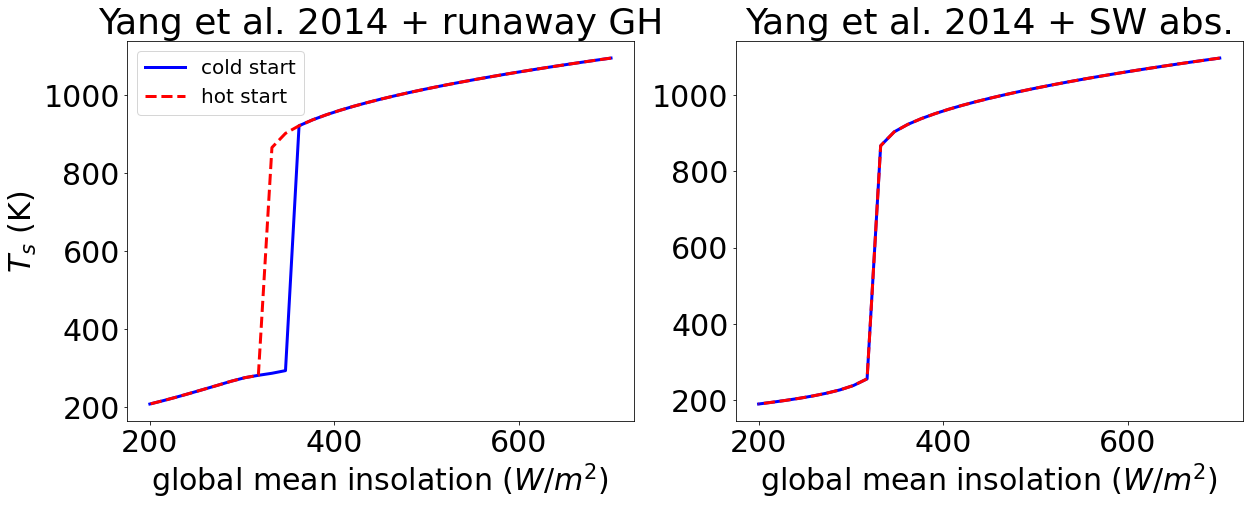

In [544]:
# print(T1_hot)
# check the results with a cold start
def plot_abs(xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(1, 2, figsize=(20,7)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0].plot(so_cold/4, (T1_cold_r+T4_cold_r)/2, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax[0].plot(so_hot/4, (T1_hot_r+T4_hot_r)/2, '--', color = 'red', linewidth=3, label = r'hot start')
    ax[0].set_ylabel(r'$T_s$ (K)')
    ax[0].set_xlabel(r'global mean insolation ($W/m^2$)')
    ax[0].set_title(r'Yang et al. 2014 + runaway GH')
    ax[0].legend(loc = 'upper left',fontsize=20,)
    
    ax[1].plot(so_cold/4, (T1_cold_0N2+T4_cold_0N2)/2, '-', color = 'blue',linewidth=3)
    ax[1].plot(so_hot/4, (T1_hot_0N2+T4_hot_0N2)/2, '--', color = 'red', linewidth=3)
#     ax[1].set_ylabel(r'T_s (K)')
    ax[1].set_xlabel(r'global mean insolation ($W/m^2$)')
    ax[1].set_title(r'Yang et al. 2014 + SW abs.')
#     ax[1].legend()
    
#     ax[1,0].plot(so_cold, ap_cold,'-', color = 'blue',linewidth=3)
#     ax[1,0].plot(so_hot, ap_hot,'--',color = 'red',linewidth=3)
# #     ax[1,0].set_xlim([1000, 2500])
#     ax[1,0].set_title('planetary albedo')
#     ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
# #     ax[1,0].legend()
    
# #     # Dayside energy budgets
#     ax[1,1].plot(so_cold, fc_cold,'-', color = 'blue',linewidth=3)
#     ax[1,1].plot(so_hot, fc_hot,'--', color = 'red',linewidth=3)
# #     ax[1,1].plot(so_cold, F3_cold,'-', color = 'red',linewidth=3, label = r'$F_{3}$')
# #     ax[1,1].plot(so_cold, Fc_cold,':', color = 'red',linewidth=3, label = r'$F_{c}$')
# #     ax[1,1].set_xlim([1000, 2500])
#     ax[1,1].set_title('dayside cloud fraction')
#     ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
# #     ax[1,1].set_ylabel(r'$W/m^2$')
# #     ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()

In [84]:
# # print(output_list)
# print(output_list[1]['T1'])
# for output in output_list:
#     print(output['T1'])
    
# extract all T1 values from output_list
Fc_values = np.array([d['Fc'] for d in cold_list])

# print the resulting array
print(Fc_values)

[162.70946625 168.0998402  173.40243836 178.96620408 184.53081489
 190.02984045 195.53492602 200.93333891 206.44667639 211.92077296
 217.37710531 222.96422396 228.52570101 234.09963325 239.72360927
 245.35919105 251.05931061 256.85570356 262.67991711 268.57606771
 274.58489978 280.61899831 286.70083964 292.9260083  299.15906461
 305.39506946 311.74819856 318.10469692 324.43755248 330.81757242
 337.20701301 343.54358854 349.92061142 356.3060768  362.60809965]


In [85]:
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
warm_list = []

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
                 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    output = feedback_func(So = s, epsl0 = 0.5, a0 = 0, \
                           LW = 'constant', SW = 'constant', TOA = 'runaway', \
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution \n")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        warm_list.append(nan_dict)
              
    else:
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        warm_list.append(output)

0 2500.0
We have a solution:  (287.1003211078769, 263.34622403969627, 263.34622403969627, 243.32276077198034, 312.01478560961266, 362.60809955878807)


1 2450.0
We have a solution:  (285.9826114918731, 261.7132845450908, 261.7132845450908, 241.86560332619314, 305.166832062276, 356.306076768373)


2 2400.0
We have a solution:  (284.87064891008436, 260.08934986480733, 260.08934986480733, 240.4060390674933, 298.3120058806905, 349.9206112819884)


3 2350.0
We have a solution:  (283.73405960172875, 258.4332163941264, 258.4332163941264, 238.91827986924193, 291.4516430167719, 343.5435884578319)


4 2300.0
We have a solution:  (282.5619474722618, 256.73265378975884, 256.73265378975884, 237.3943447236914, 284.58694243232316, 337.20701301196766)


5 2250.0
We have a solution:  (281.3861417129445, 255.03755793909434, 255.03755793909434, 235.86542551779573, 277.71768516089986, 330.81757241620227)


6 2200.0
We have a solution:  (280.18550888386983, 253.32115468055608, 253.32115468055608, 234.31429

In [87]:
# extract all T1 values from output_list
T1_cold = np.array([d['T1'] for d in cold_list])
T1_warm = np.array([d['T1'] for d in warm_list])

T2_cold = np.array([d['T2'] for d in cold_list])
T2_warm = np.array([d['T2'] for d in warm_list])

T3_cold = np.array([d['T3'] for d in cold_list])
T3_warm = np.array([d['T3'] for d in warm_list])

T4_cold = np.array([d['T4'] for d in cold_list])
T4_warm = np.array([d['T4'] for d in warm_list])

fc_cold = np.array([d['fc'] for d in cold_list])
fc_warm = np.array([d['fc'] for d in warm_list])

ap_cold = np.array([d['alpha_b'] for d in cold_list])
ap_warm = np.array([d['alpha_b'] for d in warm_list])

e2_cold = np.array([d['epsl_2'] for d in cold_list])
e2_warm = np.array([d['epsl_2'] for d in warm_list])

a2_cold = np.array([d['a_2'] for d in cold_list])
a2_warm = np.array([d['a_2'] for d in warm_list])

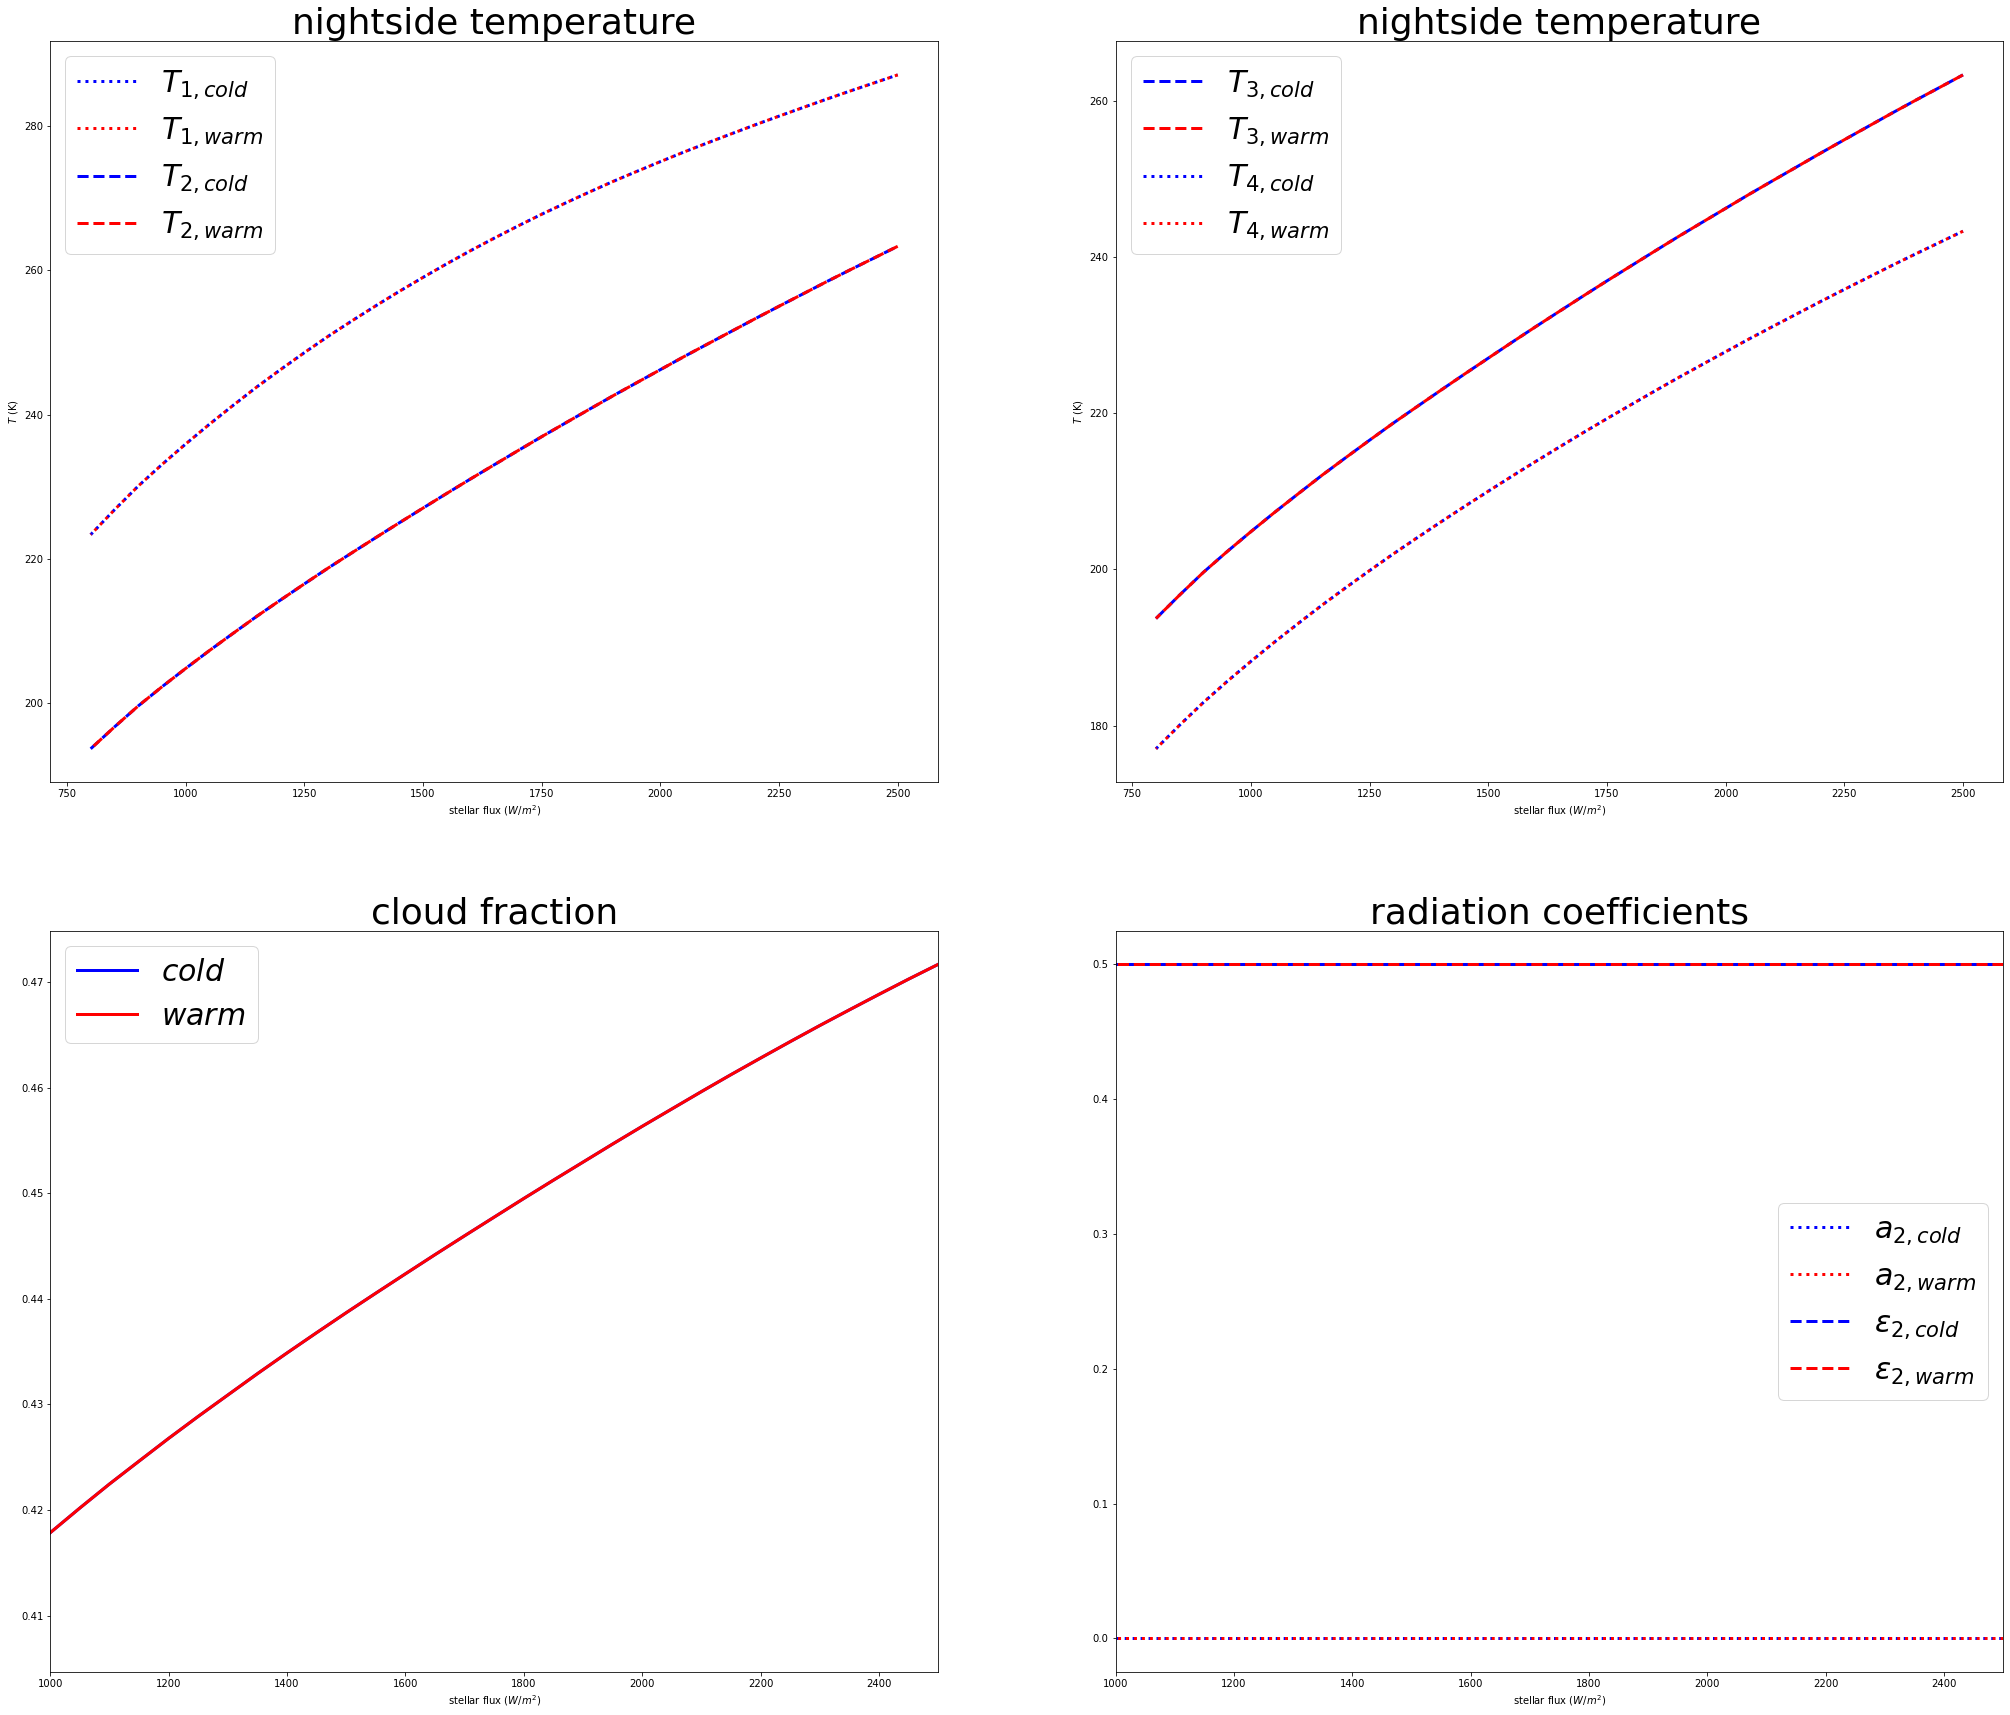

In [88]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,30)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(np.flip(so), T1_cold, ':', color = 'blue',linewidth=3, label = r'$T_{1, cold}$')
    ax[0,0].plot(so, T1_warm, ':', color = 'red', linewidth=3, label = r'$T_{1, warm}$')
    ax[0,0].plot(np.flip(so), T2_cold, '--', color = 'blue', linewidth=3, label = r'$T_{2, cold}$')
    ax[0,0].plot(so, T2_warm, '--', color = 'red',linewidth=3, label = r'$T_{2, warm}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title(r'nightside temperature')
    ax[0,0].legend()
    
#     # Nightside temperature structure
    ax[0,1].plot(np.flip(so), T3_cold, '--', color = 'blue',linewidth=3, label = r'$T_{3, cold}$')
    ax[0,1].plot(so, T3_warm, '--', color = 'red', linewidth=3, label = r'$T_{3, warm}$')
    ax[0,1].plot(np.flip(so), T4_cold, ':', color = 'blue', linewidth=3, label = r'$T_{4, cold}$')
    ax[0,1].plot(so, T4_warm, ':', color = 'red',linewidth=3, label = r'$T_{4, warm}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].set_title(r'nightside temperature')
    ax[0,1].legend()
    
#     # Dayside energy budgets
    ax[1,0].plot(np.flip(so), fc_cold,'-', color = 'blue',linewidth=3, label = r'${cold}$')
    ax[1,0].plot(so, fc_warm,'-',color = 'red',linewidth=3, label = r'${warm}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_title('cloud fraction')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
#     # Dayside energy budgets
    ax[1,1].plot(np.flip(so), a2_cold,':', color = 'blue',linewidth=3, label = r'$a_{2, cold}$')
    ax[1,1].plot(so, a2_warm,':',color = 'red',linewidth=3, label = r'$a_{2, warm}$')
    ax[1,1].plot(np.flip(so), e2_cold,'--', color = 'blue',linewidth=3, label = r'$\epsilon_{2, cold}$')
    ax[1,1].plot(so, e2_warm,'--',color = 'red',linewidth=3, label = r'$\epsilon_{2, warm}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_title('radiation coefficients')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

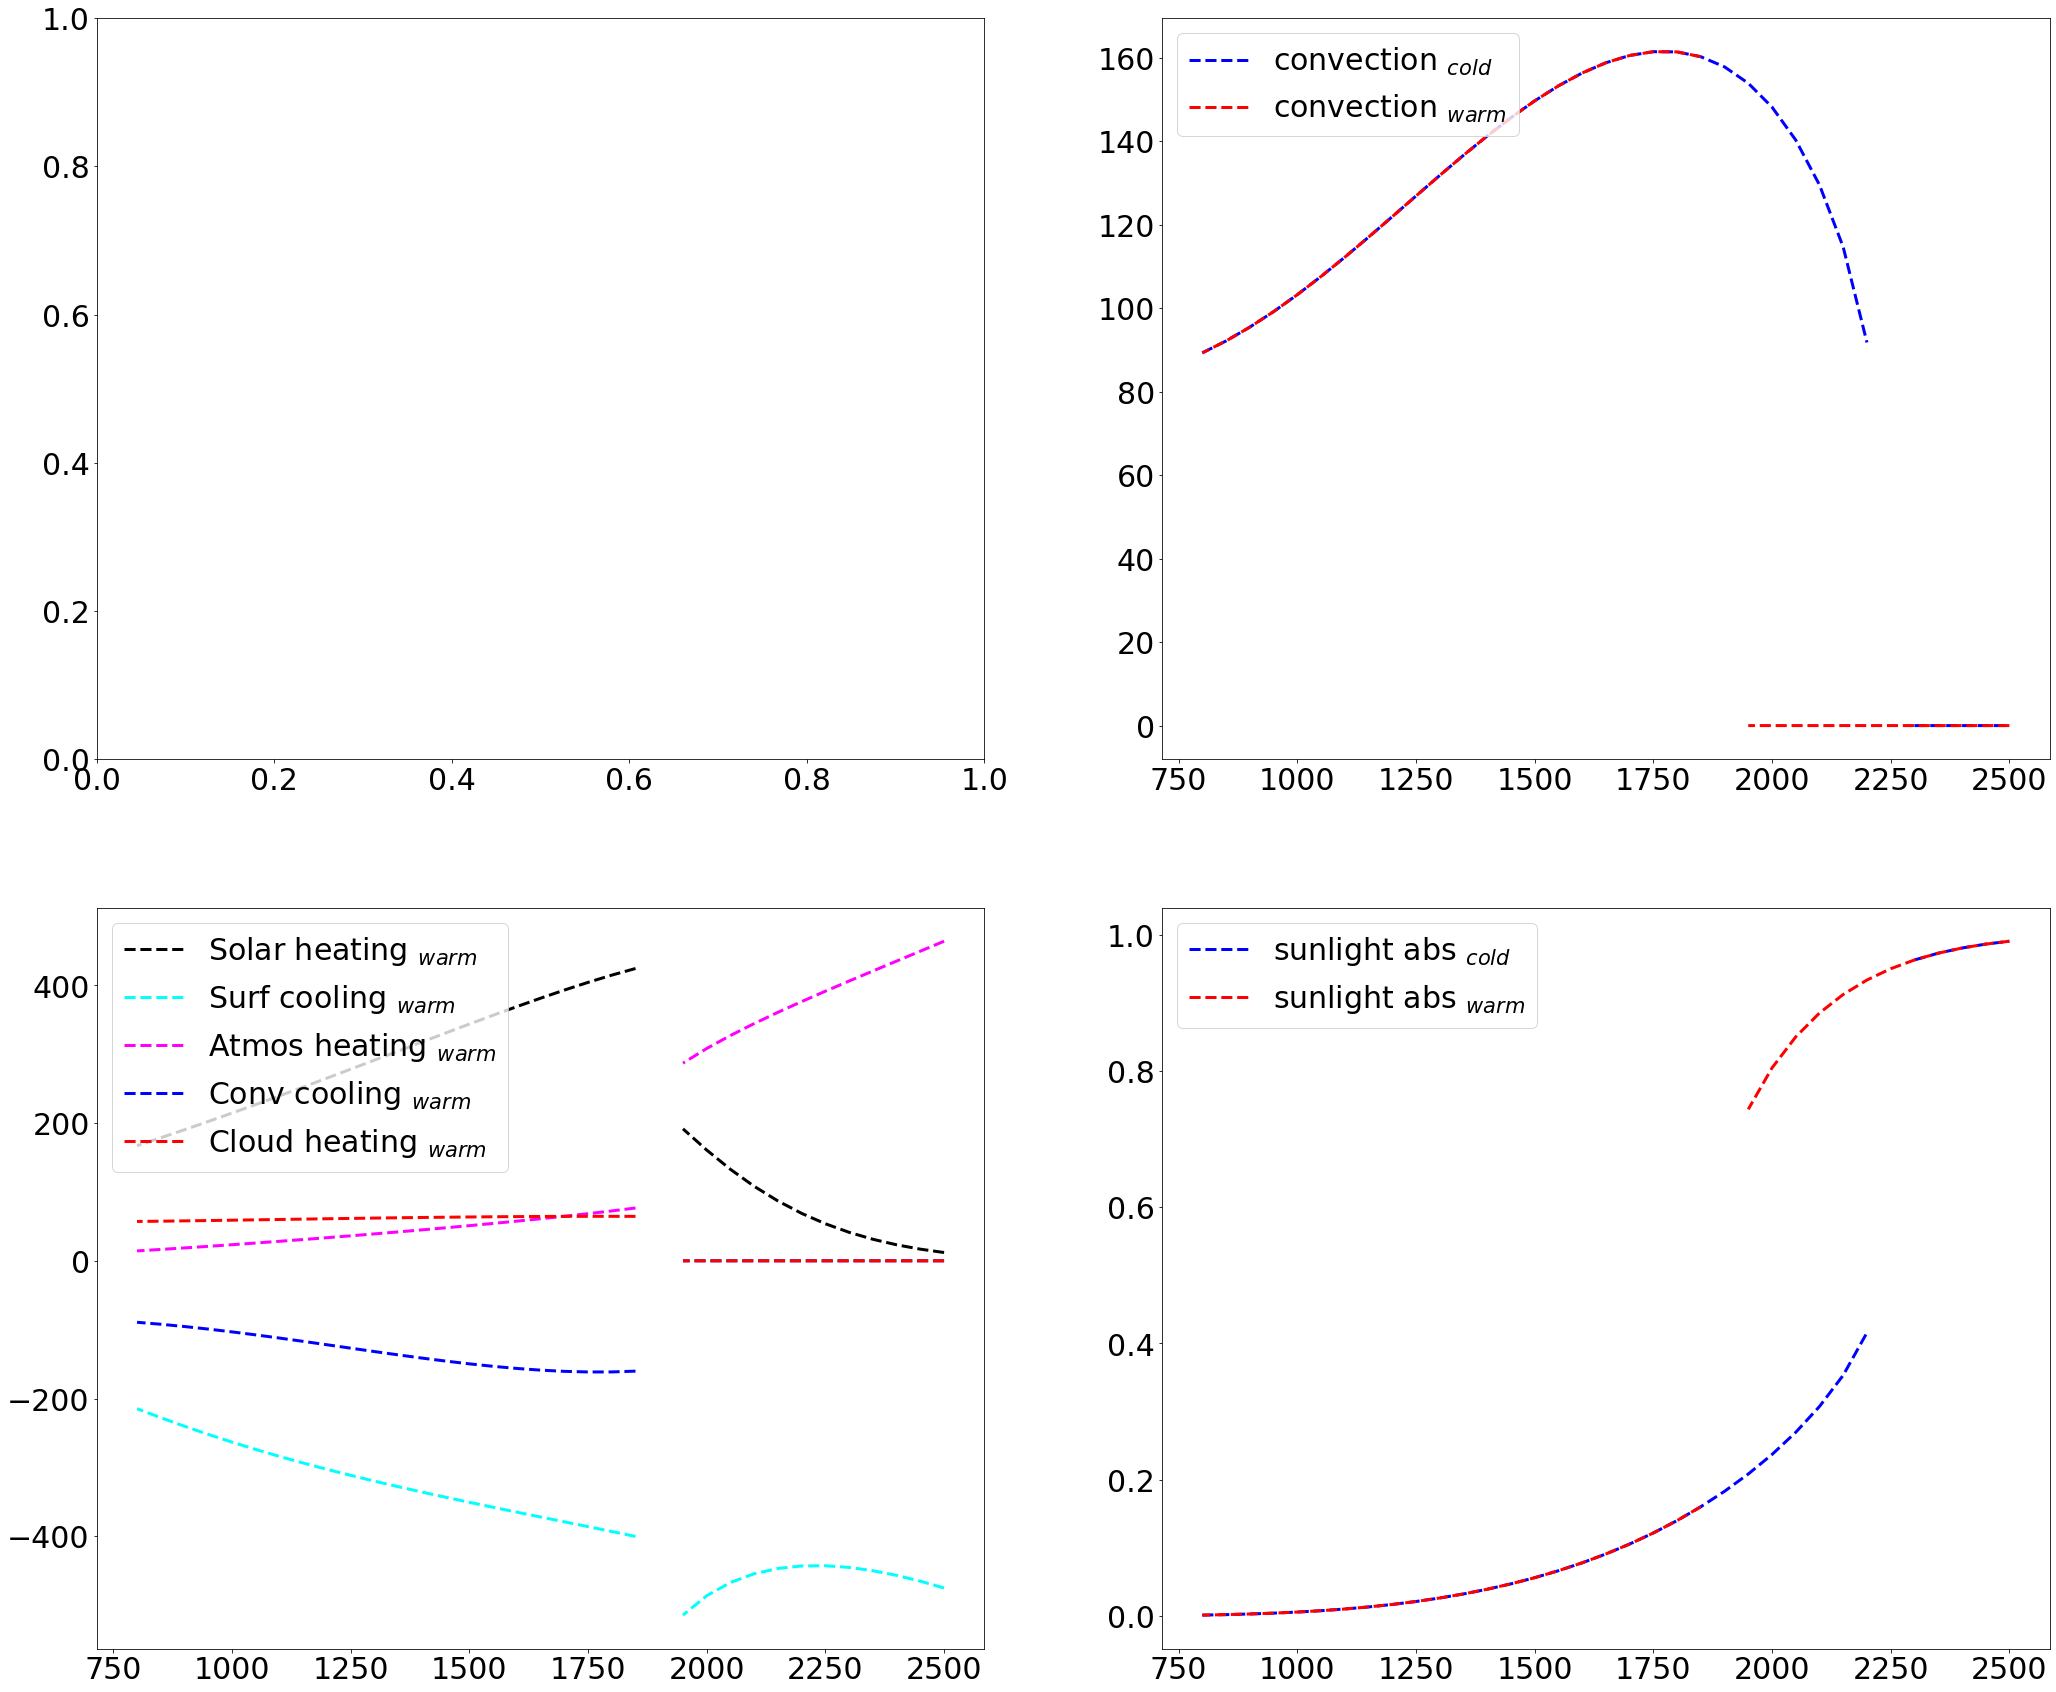

In [26]:
sigma = 5.67e-8
Tc = 230
a2_warm = np.array([d['a_2'] for d in warm_list])
a2_cold = np.array([d['a_2'] for d in cold_list])
Flux2_warm = np.array([d['Flux2'] for d in warm_list])
Fc_warm = np.array([d['Fc'] for d in warm_list])
Fc_cold = np.array([d['Fc'] for d in cold_list])

def plot_abs1(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,30)) 
    plt.rc('font', size = 30)
    ax[0,1].plot(np.flip(so), (Fc_cold),'--', color = 'blue',linewidth=3, label = r'convection $_{cold}$')
    ax[0,1].plot(so, (Fc_warm),'--', color = 'red',linewidth=3, label = r'convection $_{warm}$')
    ax[0,1].legend(loc = 2)
    
    ax[1,0].plot(so, so/2*(1-a2_warm)*(1-ap_warm),'--', color = 'black',linewidth=3, label = r'Solar heating $_{warm}$')
    ax[1,0].plot(so, -sigma*T1_warm**4,'--', color = 'cyan',linewidth=3, label = r'Surf cooling $_{warm}$')
    ax[1,0].plot(so, (1-fc_warm)*Flux2_warm,'--', color = 'magenta',linewidth=3, label = r'Atmos heating $_{warm}$')
    ax[1,0].plot(so, -Fc_warm,'--', color = 'blue',linewidth=3, label = r'Conv cooling $_{warm}$')
    ax[1,0].plot(so, fc_warm*sigma*Tc**4,'--', color = 'red',linewidth=3, label = r'Cloud heating $_{warm}$')
    ax[1,0].legend(loc = 2)
    
    ax[1,1].plot(np.flip(so), (a2_cold),'--', color = 'blue',linewidth=3, label = r'sunlight abs $_{cold}$')
    ax[1,1].plot(so, (a2_warm),'--', color = 'red',linewidth=3, label = r'sunlight abs $_{warm}$')
    ax[1,1].legend(loc = 2)
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs1(so)

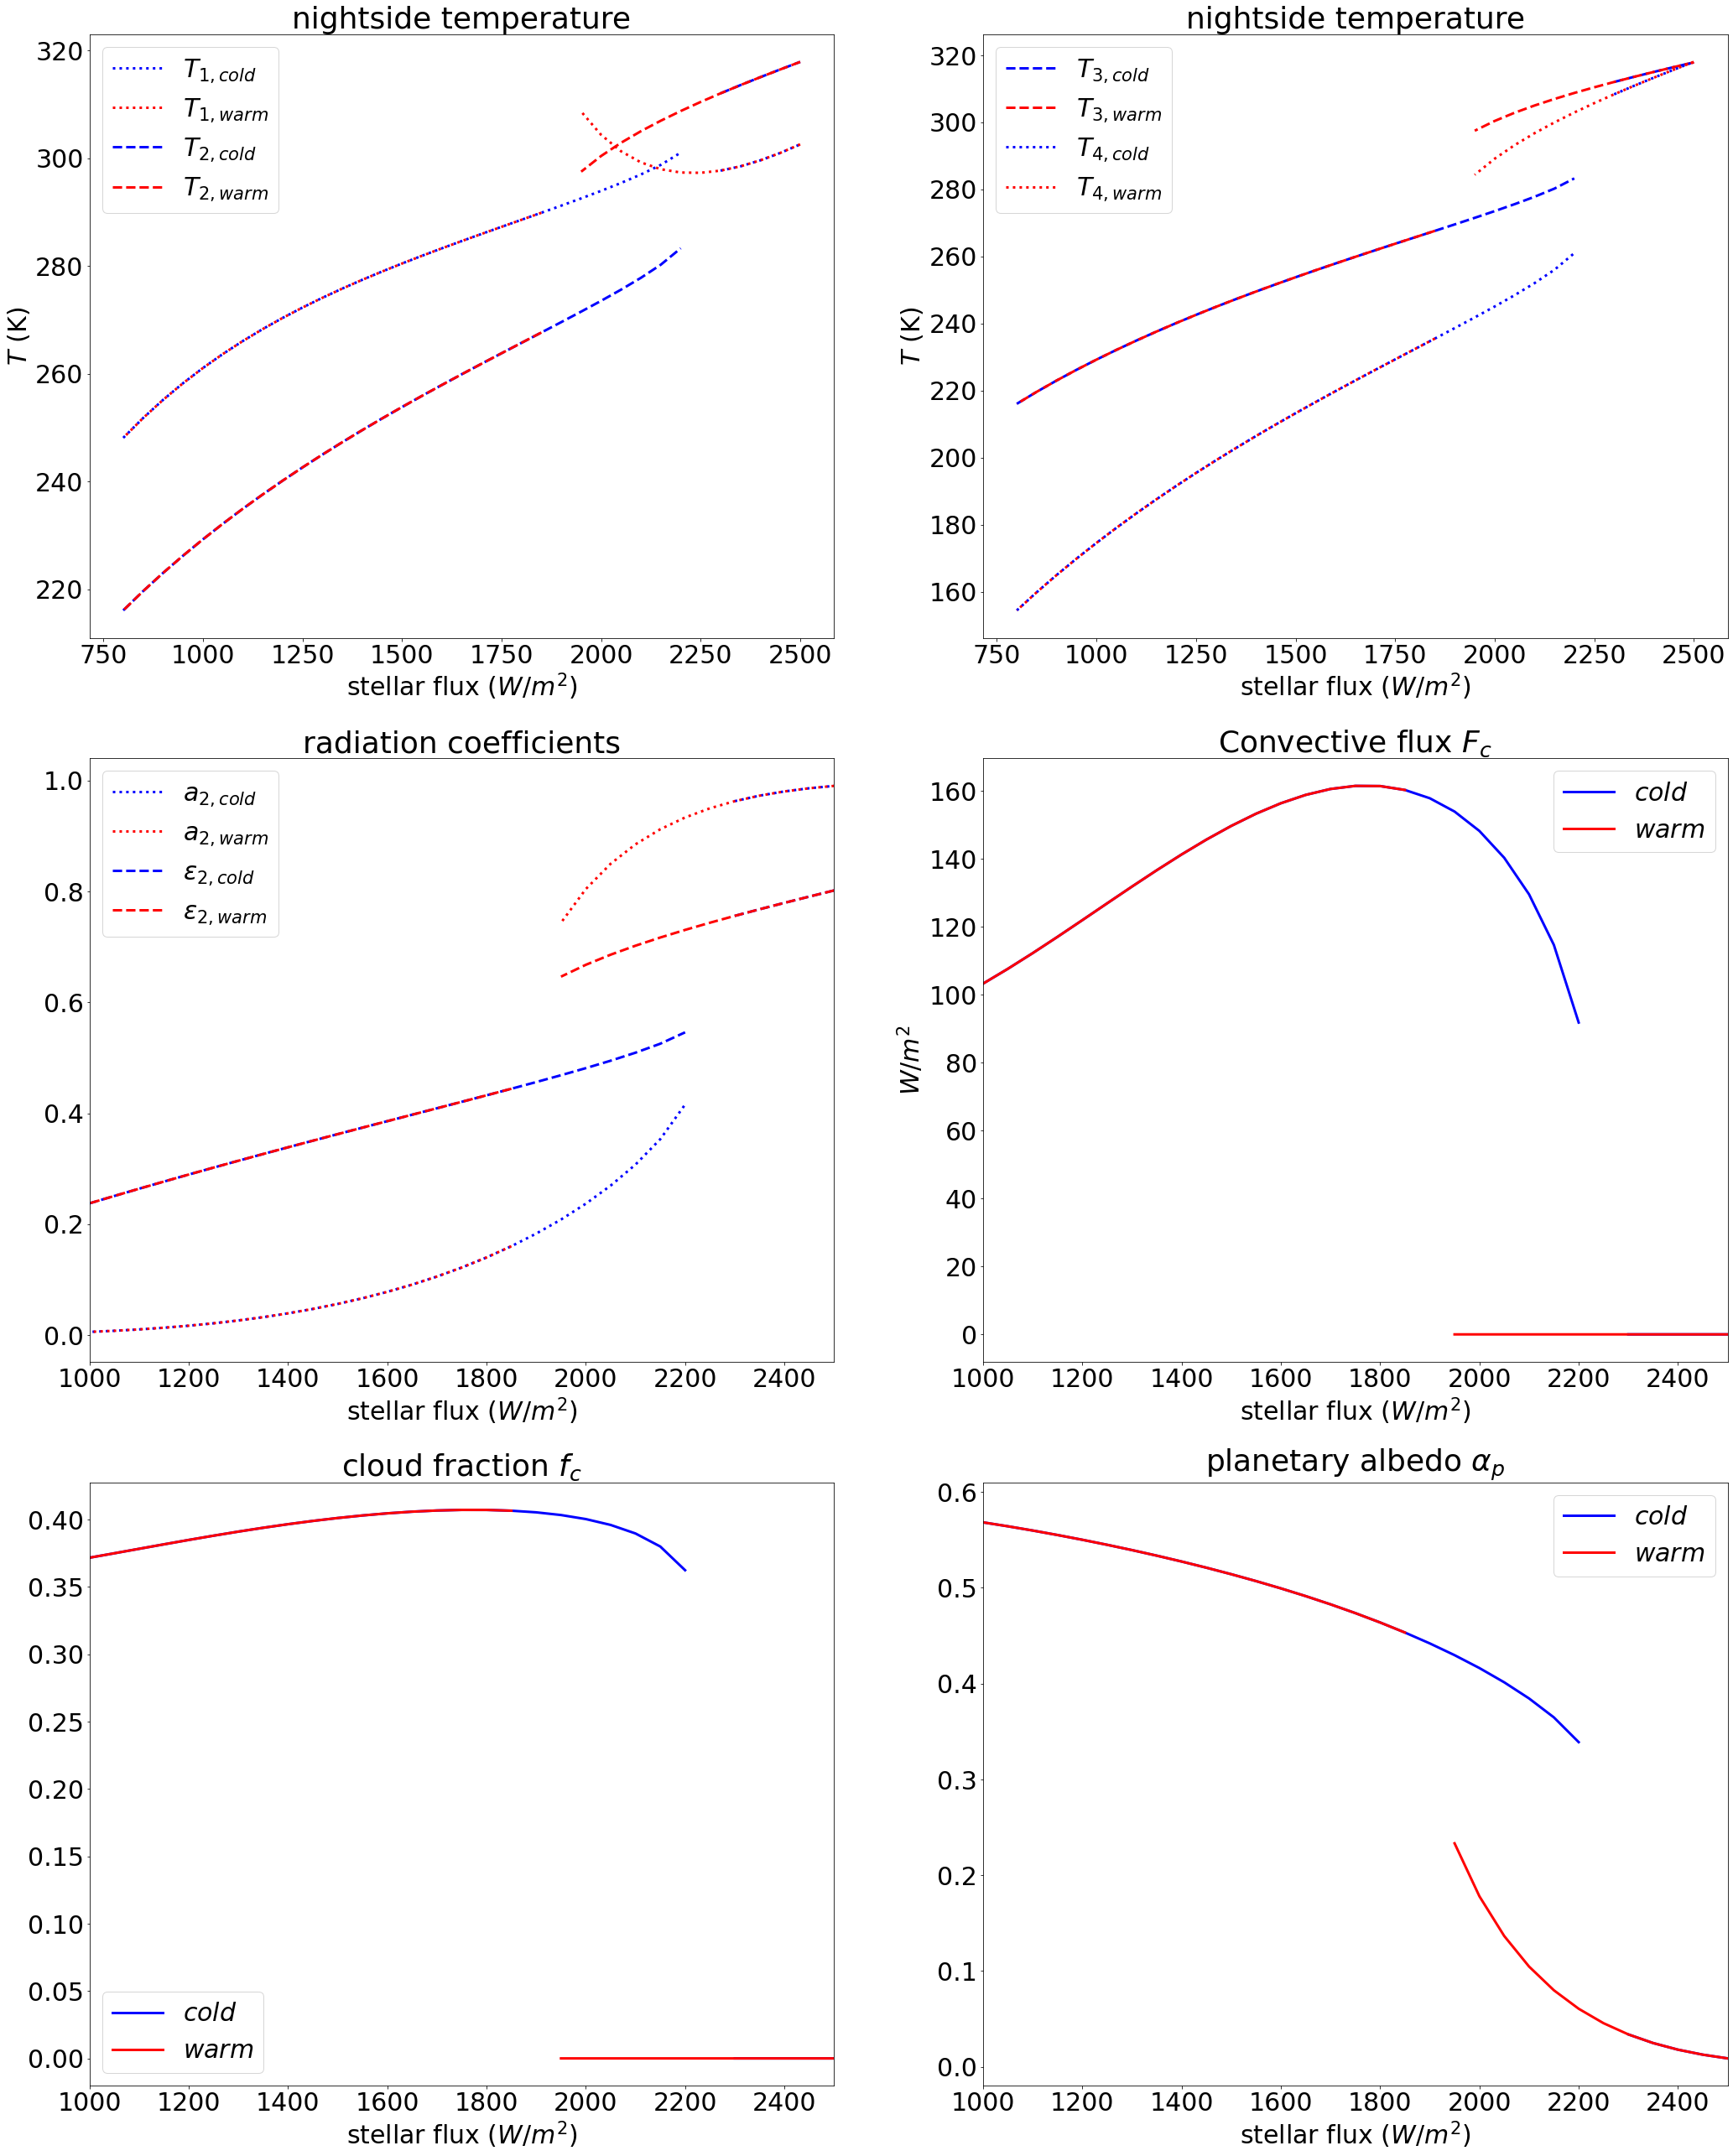

In [27]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(3, 2, figsize=(35,45)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(np.flip(so), T1_cold, ':', color = 'blue',linewidth=3, label = r'$T_{1, cold}$')
    ax[0,0].plot(so, T1_warm, ':', color = 'red', linewidth=3, label = r'$T_{1, warm}$')
    ax[0,0].plot(np.flip(so), T2_cold, '--', color = 'blue', linewidth=3, label = r'$T_{2, cold}$')
    ax[0,0].plot(so, T2_warm, '--', color = 'red',linewidth=3, label = r'$T_{2, warm}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title(r'nightside temperature')
    ax[0,0].legend()
    
#     # Nightside temperature structure
    ax[0,1].plot(np.flip(so), T3_cold, '--', color = 'blue',linewidth=3, label = r'$T_{3, cold}$')
    ax[0,1].plot(so, T3_warm, '--', color = 'red', linewidth=3, label = r'$T_{3, warm}$')
    ax[0,1].plot(np.flip(so), T4_cold, ':', color = 'blue', linewidth=3, label = r'$T_{4, cold}$')
    ax[0,1].plot(so, T4_warm, ':', color = 'red',linewidth=3, label = r'$T_{4, warm}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].set_title(r'nightside temperature')
    ax[0,1].legend()

    #     # Dayside energy budgets
    ax[1,0].plot(np.flip(so), a2_cold,':', color = 'blue',linewidth=3, label = r'$a_{2, cold}$')
    ax[1,0].plot(so, a2_warm,':',color = 'red',linewidth=3, label = r'$a_{2, warm}$')
    ax[1,0].plot(np.flip(so), e2_cold,'--', color = 'blue',linewidth=3, label = r'$\epsilon_{2, cold}$')
    ax[1,0].plot(so, e2_warm,'--',color = 'red',linewidth=3, label = r'$\epsilon_{2, warm}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_title('radiation coefficients')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
#     # Dayside energy budgets
    ax[1,1].plot(np.flip(so), Fc_cold,'-', color = 'blue',linewidth=3, label = r'${cold}$')
    ax[1,1].plot(so, Fc_warm,'-',color = 'red',linewidth=3, label = r'${warm}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_title(r'Convective flux $F_c$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].legend()
    
    #     # Dayside energy budgets
    ax[2,0].plot(np.flip(so), fc_cold,'-', color = 'blue',linewidth=3, label = r'${cold}$')
    ax[2,0].plot(so, fc_warm,'-',color = 'red',linewidth=3, label = r'${warm}$')
    ax[2,0].set_xlim([1000, 2500])
    ax[2,0].set_title(r'cloud fraction $f_c$')
    ax[2,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[2,0].legend()
    
#     # Dayside energy budgets
    ax[2,1].plot(np.flip(so), ap_cold,'-', color = 'blue',linewidth=3, label = r'${cold}$')
    ax[2,1].plot(so, ap_warm,'-',color = 'red',linewidth=3, label = r'${warm}$')
    ax[2,1].set_xlim([1000, 2500])
    ax[2,1].set_title(r'planetary albedo $\alpha_p$')
    ax[2,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[2,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

In [9]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(1000,2500,16) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_brrr, T2_brrr, T3_brrr, T4_brrr, Fa_brrr, Fc_brrr, fc_brrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_brrr, q2_brrr, q3_brrr, alpha_p_brrr, epsilon_2_brrr, epsilon_3_brrr, OLR1_brrr, OLR2_brrr, Flux1_brrr, Flux2_brrr, Flux3_brrr, Flux4_brrr, FluxC_brrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (250,250,200,200,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_brrr[idx], T2_brrr[idx], T3_brrr[idx], T4_brrr[idx], Fa_brrr[idx], Fc_brrr[idx], fc_brrr[idx], \
        q1_brrr[idx],q2_brrr[idx],q3_brrr[idx],alpha_p_brrr[idx],epsilon_2_brrr[idx],epsilon_3_brrr[idx], \
        OLR1_brrr[idx], OLR2_brrr[idx], Flux1_brrr[idx], Flux2_brrr[idx], Flux3_brrr[idx], Flux4_brrr[idx], FluxC_brrr[idx], info,ier,msg = solar_abs_func(So = s, a_2 = 0.9, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    initial_guess = (T1_brrr[idx], T2_brrr[idx], T3_brrr[idx], T4_brrr[idx], Fa_brrr[idx], Fc_brrr[idx])
    #print('end of loop ',initial_guess)

0 1000.0
We have a solution:  (282.21315000066875, 256.3633243285355, 256.3633243285355, 222.2749409838954, 182.7011790699473, -127.70554027494097)
1 1100.0
We have a solution:  (285.02293429070187, 260.4883474043525, 260.4883474043525, 238.29159313980216, 224.17169522480614, -98.32630194998643)
2 1200.0
We have a solution:  (287.7680993195153, 264.5444337347483, 264.5444337347483, 252.73645885007238, 261.2397859384492, -74.16444635448123)
3 1300.0
We have a solution:  (290.65926707314543, 268.79358172180446, 268.79358172180446, 266.03349862839303, 293.12220813149736, -56.09524023535749)
4 1400.0
We have a solution:  (293.84995753723643, 273.40152096754827, 273.40152096754827, 277.99123287642396, 319.70191245957795, -43.73660884314195)
5 1500.0
We have a solution:  (297.2986904352026, 278.2371403319143, 278.2371403319143, 287.76572786574803, 342.63168145661837, -35.057938091340134)
6 1600.0
We have a solution:  (300.78071678595154, 282.93860344734844, 282.93860344734844, 294.9992683805

In [75]:
# check the role of atmospheric circulation (Fa = 0)

''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def no_circ_func(So=1360, Fo=0, a_2 = 0.5, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, Fc = p 
#         T1, T2, T3, T4, Fa, Fc = p     
        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
#         RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
#         # water vapor calculations for nightside atmosphere
#         es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
#         ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
#         w_3 = RH3 * ws_3
#         q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
#         k2 = 1000 # Relates water vapor to the infrared opacity (need to be checked)
        k2 = 10
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        if Fc + 1.0 <= 0:
#             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))
        
        epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
#         epsilon_3 = 1 - np.exp(-k2*q3)
        
#         a_2 = 0.9 # water vapor absorption to sunlight
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a_2) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a_2 + Fc + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

#         Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

#         Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
#         Eq6_WTG = T2 - T3      # weak temperature gradient assumption

#         Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
#         # nightside outgoing longwave radiation
#         OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
#         Flux3 = epsilon_3*sigma*T3**4
#         Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
#             Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
#             Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq7)
#             return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2)
#             return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
#     (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution w/ conv.: ', (T1, T2, Fc))
        Es = T1**4
        Ea = T2**4 
        print('The average atmosphere-surface energy ratio is:', (Ea/Es))
        if Fc <= 0:
            print('Yet the solution is incorrect, solve without convection')
    
#         print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
#     fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
#     if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#         print('cloud fraction: ',fc_2)
#         fc_2 = 1
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,alpha_p,epsilon_2,OLR_day, Flux1, Flux2 = equations((T1, T2, Fc))
#     fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, Fc, fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2, FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, Fc, fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2, FluxC, info,ier,msg)
#     if debug==False: # Clean mode, only output prescribed variables
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
#     else:            # Debug mode, output the messages from fsolve function
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [76]:
# check the role of atmospheric circulation (Fa = 0)

''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def no_circ_func_ver2(So=1360, Fo=0, a_2 = 0.5, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250), debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2 = p 
#         T1, T2, T3, T4, Fa, Fc = p     
        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
#         RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
#         # water vapor calculations for nightside atmosphere
#         es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
#         ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
#         w_3 = RH3 * ws_3
#         q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
#         k2 = 1000 # Relates water vapor to the infrared opacity (need to be checked)
        k2 = 10
    
        Fd = 0
        Fc = 0
        fc = 0
#         if Fc + 1.0 <= 0:
# #             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
#             fc = 0
#         else:
#             fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
#             if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#                 print("Cloud fraction too high, corrected as 1")
#                 fc = 1
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))
        
        epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
#         epsilon_3 = 1 - np.exp(-k2*q3)
        
#         a_2 = 0.9 # water vapor absorption to sunlight
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a_2) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a_2 + Fc + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

#         Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

#         Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
#         Eq6_WTG = T2 - T3      # weak temperature gradient assumption

#         Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

#         Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
#         # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
#         Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
#         # nightside outgoing longwave radiation
#         OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
#         Flux3 = epsilon_3*sigma*T3**4
#         Flux4 = (1-epsilon_3)*sigma*T3**4
        
#         if assumption == 'WTG':                         
# #             Eq6 = Eq6_WTG
#             Eq7 = Eq7_WTG                       
#         elif assumption == 'WBG':
# #             Eq6  = Eq6_WBG
#             Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3)
#             return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2)
#             return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2), info, ier, msg = fsolve(equations, p_guess, full_output=True)
#     (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution w/o conv.: ', (T1, T2))
        Es = T1**4
        Ea = T2**4 
        print('The average atmosphere-surface energy ratio is:', (Ea/Es))
        print('\n')
    
#         print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
#     fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
#     if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#         print('cloud fraction: ',fc_2)
#         fc_2 = 1
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,alpha_p,epsilon_2,OLR_day, Flux1, Flux2 = equations((T1, T2))
#     fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2, FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2, FluxC, info,ier,msg)
#     if debug==False: # Clean mode, only output prescribed variables
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
#     else:            # Debug mode, output the messages from fsolve function
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [80]:
# Example debug mode
S = 1200       # W/m2
T1_init = 328  # K
T2_init = 314  # K
Fc_init = 318  # W/m2

no_circ_func(So=S, a_2 = 0.9, assumption='WTG',debug=True,\
    p_guess = (T1_init, T2_init, Fc_init))


We have a solution w/ conv.:  (317.67972456437906, 303.3723044127005, -367.33619169740354)
The average atmosphere-surface energy ratio is: 0.8316598428431469
Yet the solution is incorrect, solve without convection


(317.67972456437906,
 303.3723044127005,
 -367.33619169740354,
 0,
 0.058763208069445086,
 0.039138144173929974,
 0.09,
 0.3238777943842016,
 545.9999999999029,
 390.45073839665696,
 155.54926160324595,
 -0.0,
 {'nfev': 16,
  'fjac': array([[-3.63306552e-04,  1.95276329e-04,  9.99999915e-01],
         [-5.41009874e-01,  8.41016163e-01, -3.60783012e-04],
         [ 8.41016162e-01,  5.41009959e-01,  1.99900261e-04]]),
  'r': array([ 1.79462226e+04, -1.22700515e+04,  8.97795666e-04, -1.01581809e+01,
          1.42394392e+00, -3.27847618e-01]),
  'qtf': array([ 2.63965902e-06, -6.61436536e-10,  8.97294234e-10]),
  'fvec': array([2.54658516e-11, 7.15090209e-11, 4.27186023e-07])},
 1,
 'The solution converged.')

In [83]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(1000,2500,16) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_crr, T2_crr, Fc_crr, fc_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crr, q2_crr, alpha_p_crr, epsilon_2_crr, OLR1_crr, Flux1_crr, Flux2_crr, FluxC_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
# initial_guess = (250,250,20)
# initial_guess2 = (250,250)
initial_guess = (328,314,318)
initial_guess2 = (328,314)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crr[idx], T2_crr[idx], Fc_crr[idx], fc_crr[idx], \
        q1_crr[idx],q2_crr[idx],alpha_p_crr[idx],epsilon_2_crr[idx], \
        OLR1_crr[idx], Flux1_crr[idx], Flux2_crr[idx], FluxC_crr[idx], info,ier,msg = no_circ_func(So = s, a_2 = 0.5, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    if Fc_crr[idx] <= 0:
        Fc_crr[idx] = 0
        T1_crr[idx], T2_crr[idx], fc_crr[idx], \
            q1_crr[idx],q2_crr[idx],alpha_p_crr[idx],epsilon_2_crr[idx], \
            OLR1_crr[idx], Flux1_crr[idx], Flux2_crr[idx], FluxC_crr[idx], info,ier,msg = no_circ_func_ver2(So = s, a_2 = 0.9, assumption  = 'WTG', p_guess=initial_guess2, debug=True)
        
    initial_guess = (T1_crr[idx], T2_crr[idx], Fc_crr[idx])
    initial_guess2 = (T1_crr[idx], T2_crr[idx])
    #print('end of loop ',initial_guess)

0 1000.0
We have a solution w/ conv.:  (300.9613869469417, 283.1774049102892, -200.7650063635986)
The average atmosphere-surface energy ratio is: 0.7837747559886062
Yet the solution is incorrect, solve without convection
We have a solution w/o conv.:  (278.5098666364168, 314.511529380133)
The average atmosphere-surface energy ratio is: 1.6262373844798395


1 1100.0
We have a solution w/ conv.:  (309.3486891376933, 293.73506019890726, -187.54462805486443)
The average atmosphere-surface energy ratio is: 0.8128867183960744
Yet the solution is incorrect, solve without convection
We have a solution w/o conv.:  (288.2437357405411, 317.37298146392476)
The average atmosphere-surface energy ratio is: 1.4697392617806238


2 1200.0
We have a solution w/ conv.:  (317.6797245644966, 303.37230441350425, -148.936191692733)
The average atmosphere-surface energy ratio is: 0.8316598428507296
Yet the solution is incorrect, solve without convection
We have a solution w/o conv.:  (298.0429828815528, 320.37

In [56]:
print(epsilon_2_crr)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(1000,2500,16) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_crrr, T2_crrr, Fc_crrr, fc_crrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crrr, q2_crrr, alpha_p_crrr, epsilon_2_crrr, OLR1_crrr, Flux1_crrr, Flux2_crrr, FluxC_crrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (250,250,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crrr[idx], T2_crrr[idx], Fc_crrr[idx], fc_crrr[idx], \
        q1_crrr[idx],q2_crrr[idx],alpha_p_crrr[idx],epsilon_2_crrr[idx], \
        OLR1_crrr[idx], Flux1_crrr[idx], Flux2_crrr[idx], FluxC_crrr[idx], info,ier,msg = no_circ_func(So = s, a_2 = 0.9, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    initial_guess = (T1_crrr[idx], T2_crrr[idx], Fc_crrr[idx])
    #print('end of loop ',initial_guess)

0 1000.0
We have a solution:  (314.0856747961571, 299.30025333727974, -51.2922226807497)
1 1100.0
We have a solution:  (320.5227542158111, 306.5174865894208, -47.88711778755008)
2 1200.0
We have a solution:  (326.78574988630237, 313.2581623719902, -45.99970039300991)
3 1300.0
We have a solution:  (332.8383884891894, 319.58980925206725, -45.20171410179556)
4 1400.0
We have a solution:  (338.65945950512815, 325.56603723657065, -45.12322387512406)
5 1500.0
We have a solution:  (344.2397626806751, 331.23017893021455, -45.45920391790805)
6 1600.0
We have a solution:  (349.5782403231305, 336.61780218465765, -45.96056998700432)
7 1700.0
We have a solution:  (354.6789870340499, 341.75849207171865, -46.423614022609506)
8 1800.0
We have a solution:  (359.549432441618, 346.6771444951557, -46.68349825118107)
9 1900.0
We have a solution:  (364.19968765841435, 351.3949247948506, -46.6153022327873)
10 2000.0
We have a solution:  (368.64337650460385, 355.92999079029073, -46.14976566776978)
11 2100.0
W

<ipython-input-10-727aa763cdcc>:94: RuntimeWarning: overflow encountered in exp
  epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
<ipython-input-10-727aa763cdcc>:103: RuntimeWarning: invalid value encountered in double_scalars
  Eq3 = (1/2)*So*(1-alpha_p)*a_2 + Fc + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4
<ipython-input-10-727aa763cdcc>:118: RuntimeWarning: invalid value encountered in double_scalars
  OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4


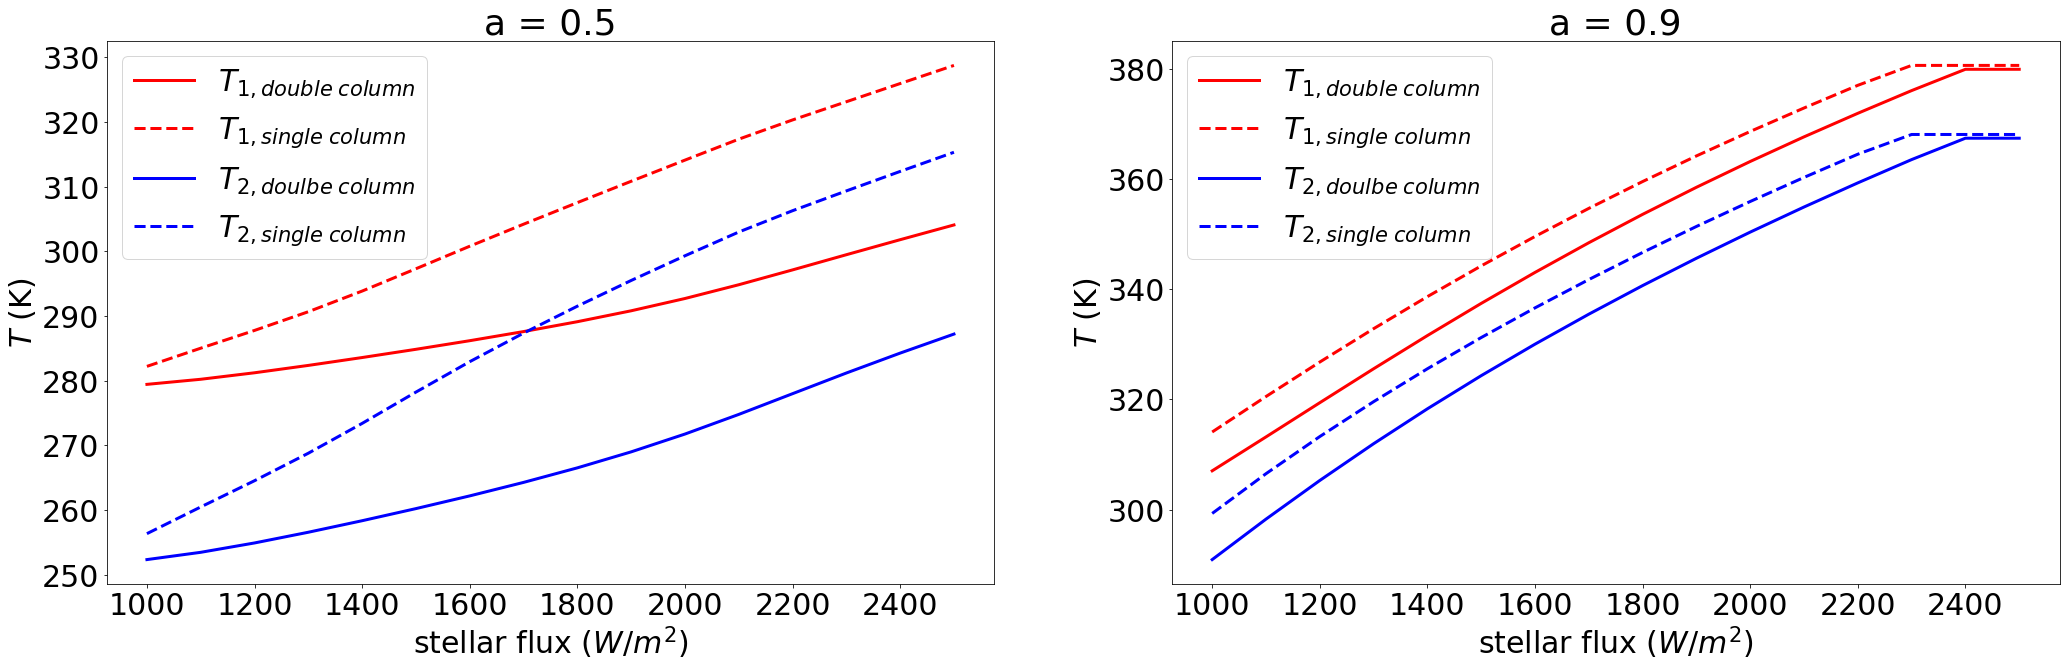

In [19]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(1, 2, figsize=(35,10)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0].plot(so, T1_brr, '-', color = 'red',linewidth=3, label = r'$T_{1, double\;column}$')
    ax[0].plot(so, T1_brrr, '--', color = 'red', linewidth=3, label = r'$T_{1, single\;column}$')
    ax[0].plot(so, T2_brr, '-', color = 'blue', linewidth=3, label = r'$T_{2, doulbe\;column}$')
    ax[0].plot(so, T2_brrr, '--', color = 'blue',linewidth=3, label = r'$T_{2, single\;column}$')
    ax[0].set_ylabel(r'$T$ (K)')
    ax[0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0].set_title(r'a = 0.5')
    ax[0].legend()
    
    # Nightside temperature structure
    ax[1].plot(so, T1_crr, '-', color = 'red',linewidth=3, label = r'$T_{1, double\;column}$')
    ax[1].plot(so, T1_crrr, '--', color = 'red', linewidth=3, label = r'$T_{1, single\;column}$')
    ax[1].plot(so, T2_crr, '-', color = 'blue', linewidth=3, label = r'$T_{2, doulbe\;column}$')
    ax[1].plot(so, T2_crrr, '--', color = 'blue',linewidth=3, label = r'$T_{2, single\;column}$')
    ax[1].set_ylabel(r'$T$ (K)')
    ax[1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1].set_title(r'a = 0.9')
    ax[1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

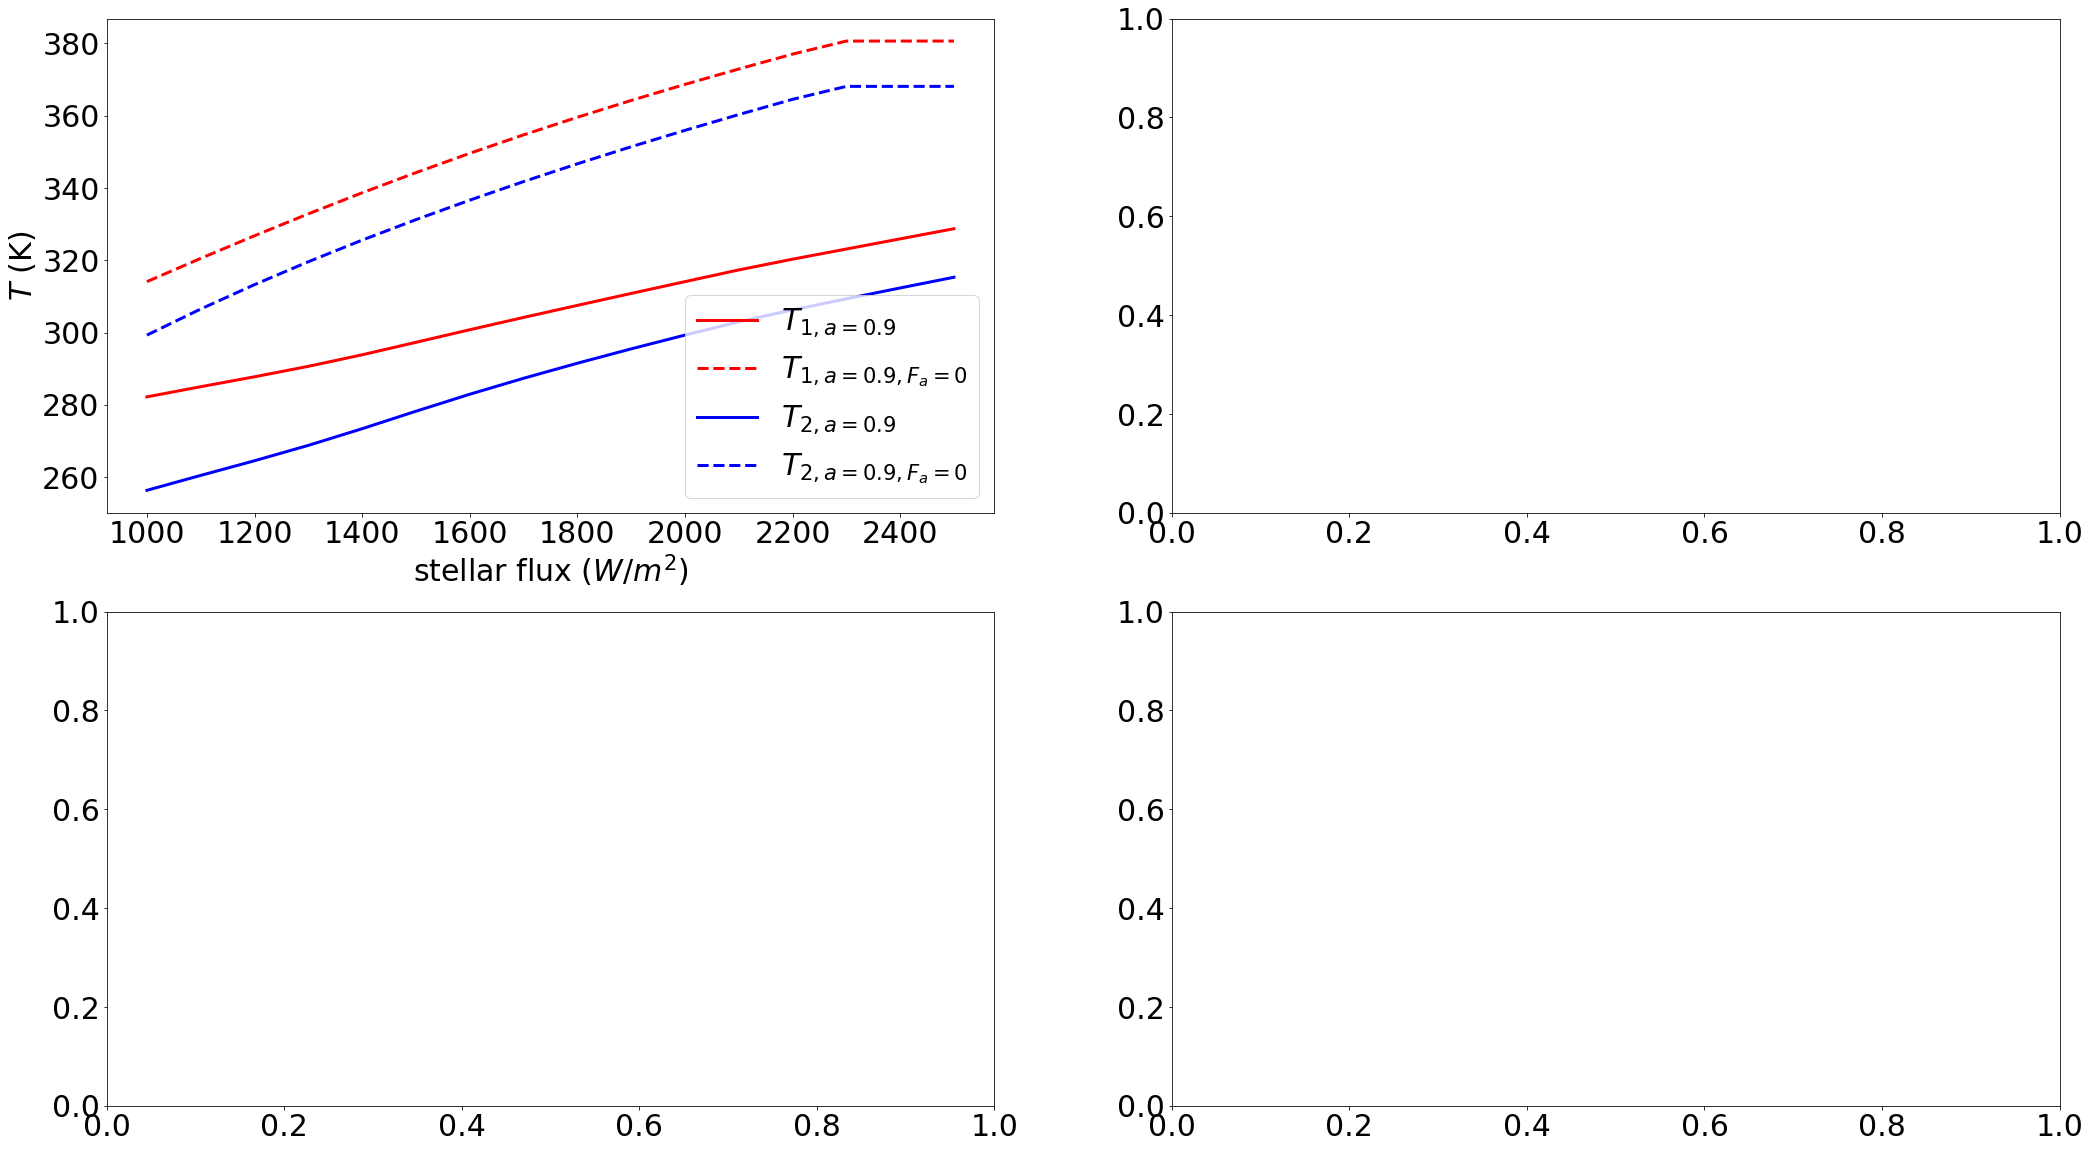

In [25]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, T1_brr, '-', color = 'red',linewidth=3, label = r'$T_{1, a=0.9}$')
    ax[0,0].plot(so, T1_crr, '--', color = 'red', linewidth=3, label = r'$T_{1, a=0.9, F_a = 0}$')
    ax[0,0].plot(so, T2_brr, '-', color = 'blue', linewidth=3, label = r'$T_{2, a=0.9}$')
    ax[0,0].plot(so, T2_crr, '--', color = 'blue',linewidth=3, label = r'$T_{2, a=0.9, F_a = 0}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
#     # Nightside temperature structure
#     ax[0,1].plot(so, T4_arr, '-', color = 'red',linewidth=3, label = r'$T_{4, a=0}$')
#     ax[0,1].plot(so, T4_brr, '--', color = 'red', linewidth=3, label = r'$T_{4, a=0.9}$')
#     ax[0,1].plot(so, T3_arr, '-', color = 'blue', linewidth=3, label = r'$T_{3, a=0}$')
#     ax[0,1].plot(so, T3_brr, '--', color = 'blue',linewidth=3, label = r'$T_{3, a=0.9}$')
#     ax[0,1].set_ylabel(r'$T$ (K)')
#     ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[0,1].legend()
    
#     # Dayside energy budgets
#     ax[1,0].plot(so, OLR1_arr,'-',linewidth=3, label = r'$OLR_{1, a=0}$')
#     ax[1,0].plot(so, OLR1_brr,'--',linewidth=3, label = r'$OLR_{1, a=0.9}$')
#     ax[1,0].set_xlim([1000, 2500])
#     ax[1,0].set_ylabel(r'$W/m^2$')
#     ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,0].legend()
    
#     # Nightside energy budgets
#     ax[1,1].plot(so, OLR2_arr,'-',linewidth=3, label = r'$OLR_{2, a=0}$')
#     ax[1,1].plot(so, OLR2_brr,'--',linewidth=3, label = r'$OLR_{2, a=0.9}$')
#     ax[1,1].set_xlim([1000, 2500])
#     ax[1,1].set_ylabel(r'$W/m^2$')
#     ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

In [72]:
print("Check variables")
print("T1 = {} K".format(round(T1_brr[0],2)))
print("T2 = {} K".format(round(T2_brr[0],2)))
print("T3 = {} K".format(round(T3_brr[0],2)))
print("T4 = {} K".format(round(T4_brr[0],2)))
print("F_a = {} W/m2".format(round(Fa_brr[0],2)))
print("F_c = {} W/m2".format(round(Fc_brr[0],2)))
print("dayside cloud fraction = {}".format(round(fc_brr[0],2)))
print("dayside surface specific humidity = {} kg/kg".format(round(q1_brr[0],4)))
print("dayside atmos specific humidity = {} kg/kg".format(round(q2_brr[0],4)))
print("nightside atmos specific humidity = {} kg/kg".format(round(q3_brr[0],6)))
print("planetary albedo = {}".format(round(alpha_p_brr[0],3)))
print("dayside emissivity = {}".format(round(epsilon_2_brr[0],3)))
print("nightside emissivity = {}".format(round(epsilon_3_brr[0],3)))
print("dayside OLR = {} W/m2".format(round(OLR1_brr[0],1)))
print("nightside OLR = {} W/m2".format(round(OLR2_brr[0],1)))
print("dayside surface cooling = {} W/m2".format(round(Flux1_brr[0],1)))
print("dayside atmospheric cooling = {} W/m2".format(round(Flux2_brr[0],1)))
print("dayside cloud radiative effect = {} W/m2".format(round(FluxC_brr[0],1)))
print("nightside surface cooling = {} W/m2".format(round(Flux3_brr[0],1)))
print("nightside atmospheric cooling = {} W/m2".format(round(Flux4_brr[0],1)))

Check variables
T1 = 279.43 K
T2 = 252.35 K
T3 = 252.35 K
T4 = 205.9 K
F_a = 142.75 W/m2
F_c = 3.43 W/m2
dayside cloud fraction = 0.12
dayside surface specific humidity = 0.0055 kg/kg
dayside atmos specific humidity = 0.001 kg/kg
nightside atmos specific humidity = 0.000384 kg/kg
planetary albedo = 0.198
dayside emissivity = 0.641
nightside emissivity = 0.319
dayside OLR = 258.1 W/m2
nightside OLR = 142.8 W/m2
dayside surface cooling = 124.2 W/m2
dayside atmospheric cooling = 147.4 W/m2
dayside cloud radiative effect = -52.0 W/m2
nightside surface cooling = 73.4 W/m2
nightside atmospheric cooling = 156.6 W/m2


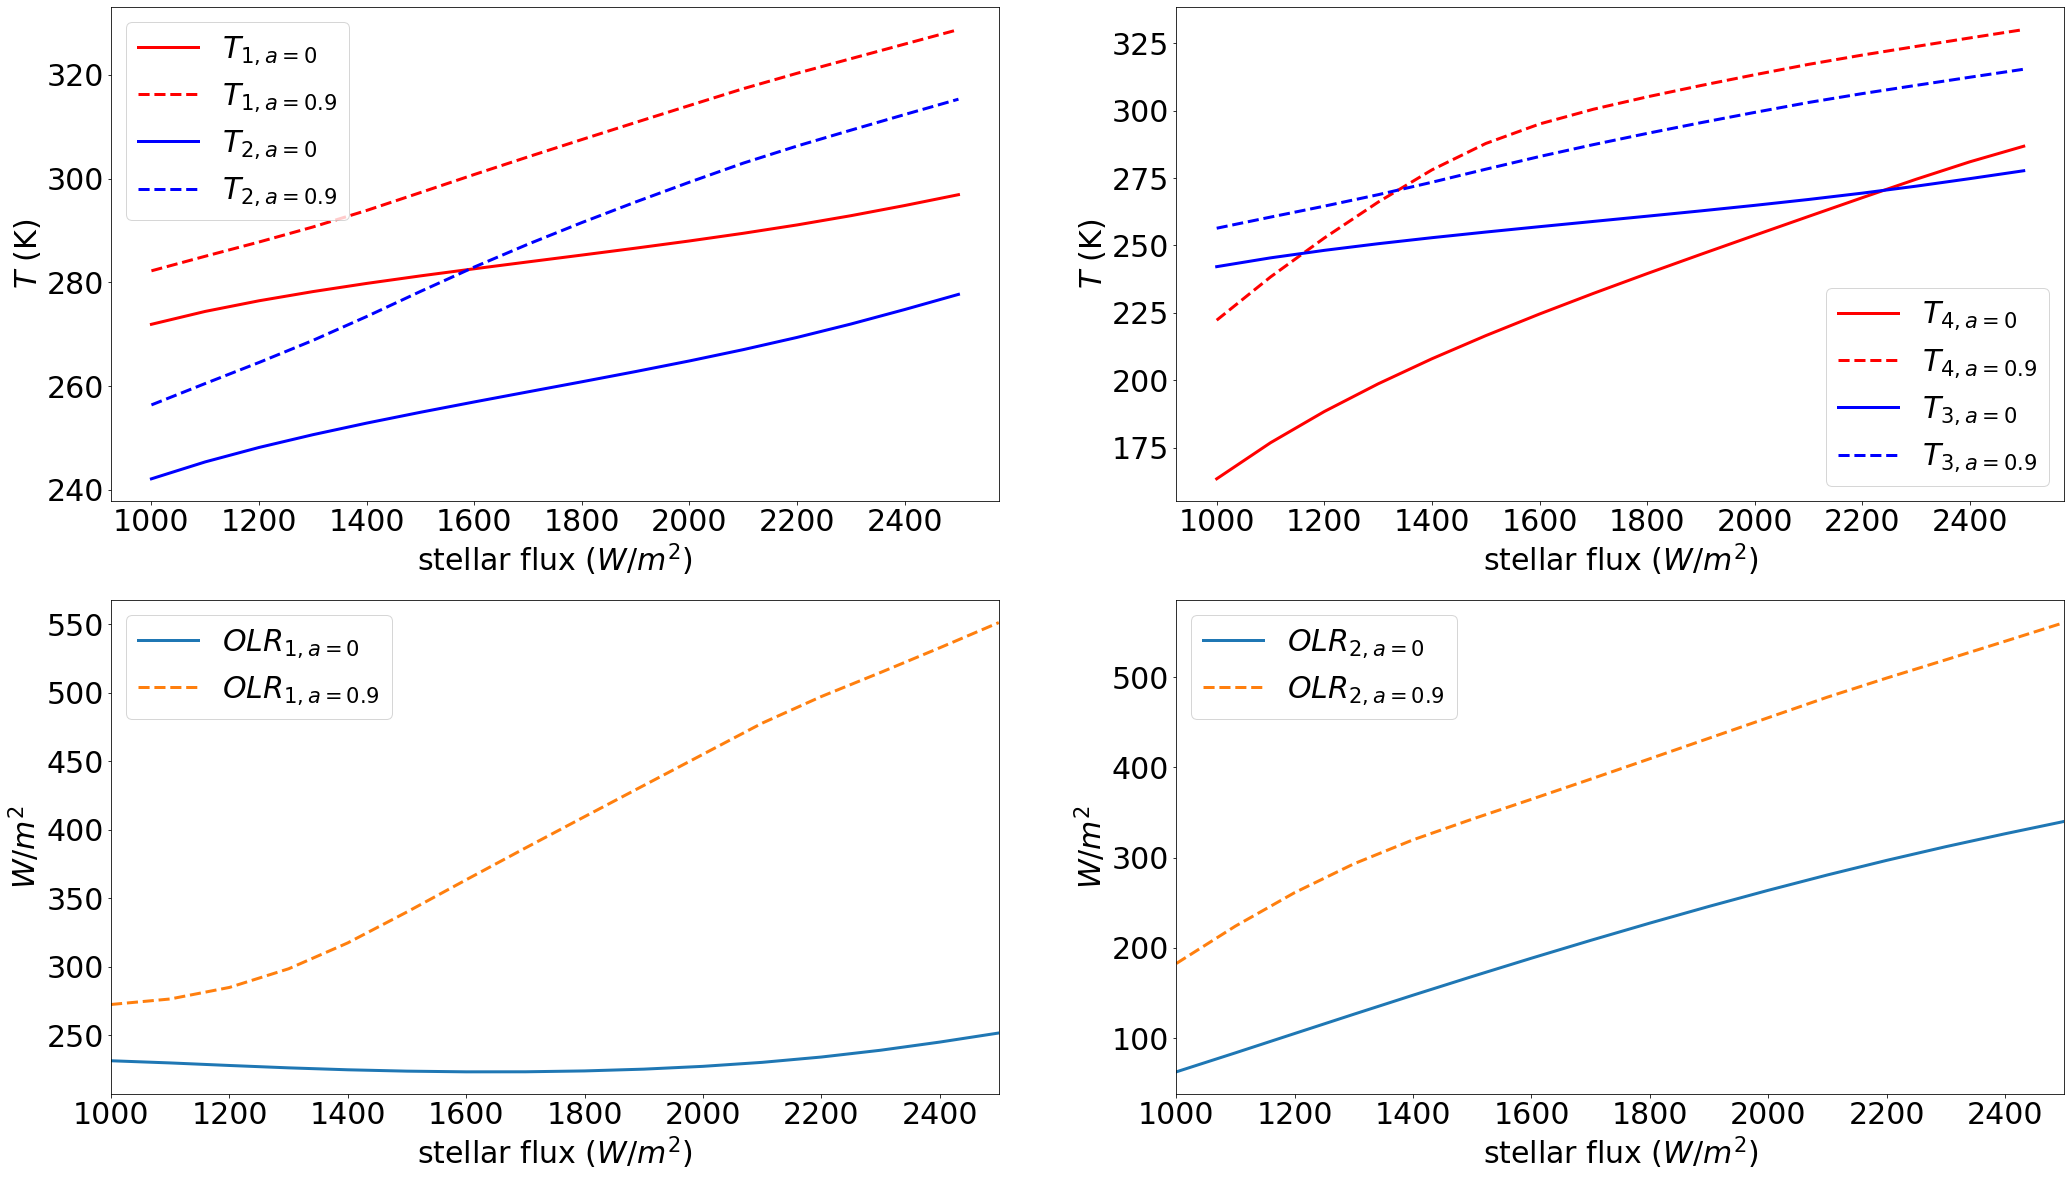

In [121]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, T1_arr, '-', color = 'red',linewidth=3, label = r'$T_{1, a=0}$')
    ax[0,0].plot(so, T1_brr, '--', color = 'red', linewidth=3, label = r'$T_{1, a=0.9}$')
    ax[0,0].plot(so, T2_arr, '-', color = 'blue', linewidth=3, label = r'$T_{2, a=0}$')
    ax[0,0].plot(so, T2_brr, '--', color = 'blue',linewidth=3, label = r'$T_{2, a=0.9}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
    # Nightside temperature structure
    ax[0,1].plot(so, T4_arr, '-', color = 'red',linewidth=3, label = r'$T_{4, a=0}$')
    ax[0,1].plot(so, T4_brr, '--', color = 'red', linewidth=3, label = r'$T_{4, a=0.9}$')
    ax[0,1].plot(so, T3_arr, '-', color = 'blue', linewidth=3, label = r'$T_{3, a=0}$')
    ax[0,1].plot(so, T3_brr, '--', color = 'blue',linewidth=3, label = r'$T_{3, a=0.9}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].legend()
    
    # Dayside energy budgets
    ax[1,0].plot(so, OLR1_arr,'-',linewidth=3, label = r'$OLR_{1, a=0}$')
    ax[1,0].plot(so, OLR1_brr,'--',linewidth=3, label = r'$OLR_{1, a=0.9}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'$W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
    # Nightside energy budgets
    ax[1,1].plot(so, OLR2_arr,'-',linewidth=3, label = r'$OLR_{2, a=0}$')
    ax[1,1].plot(so, OLR2_brr,'--',linewidth=3, label = r'$OLR_{2, a=0.9}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

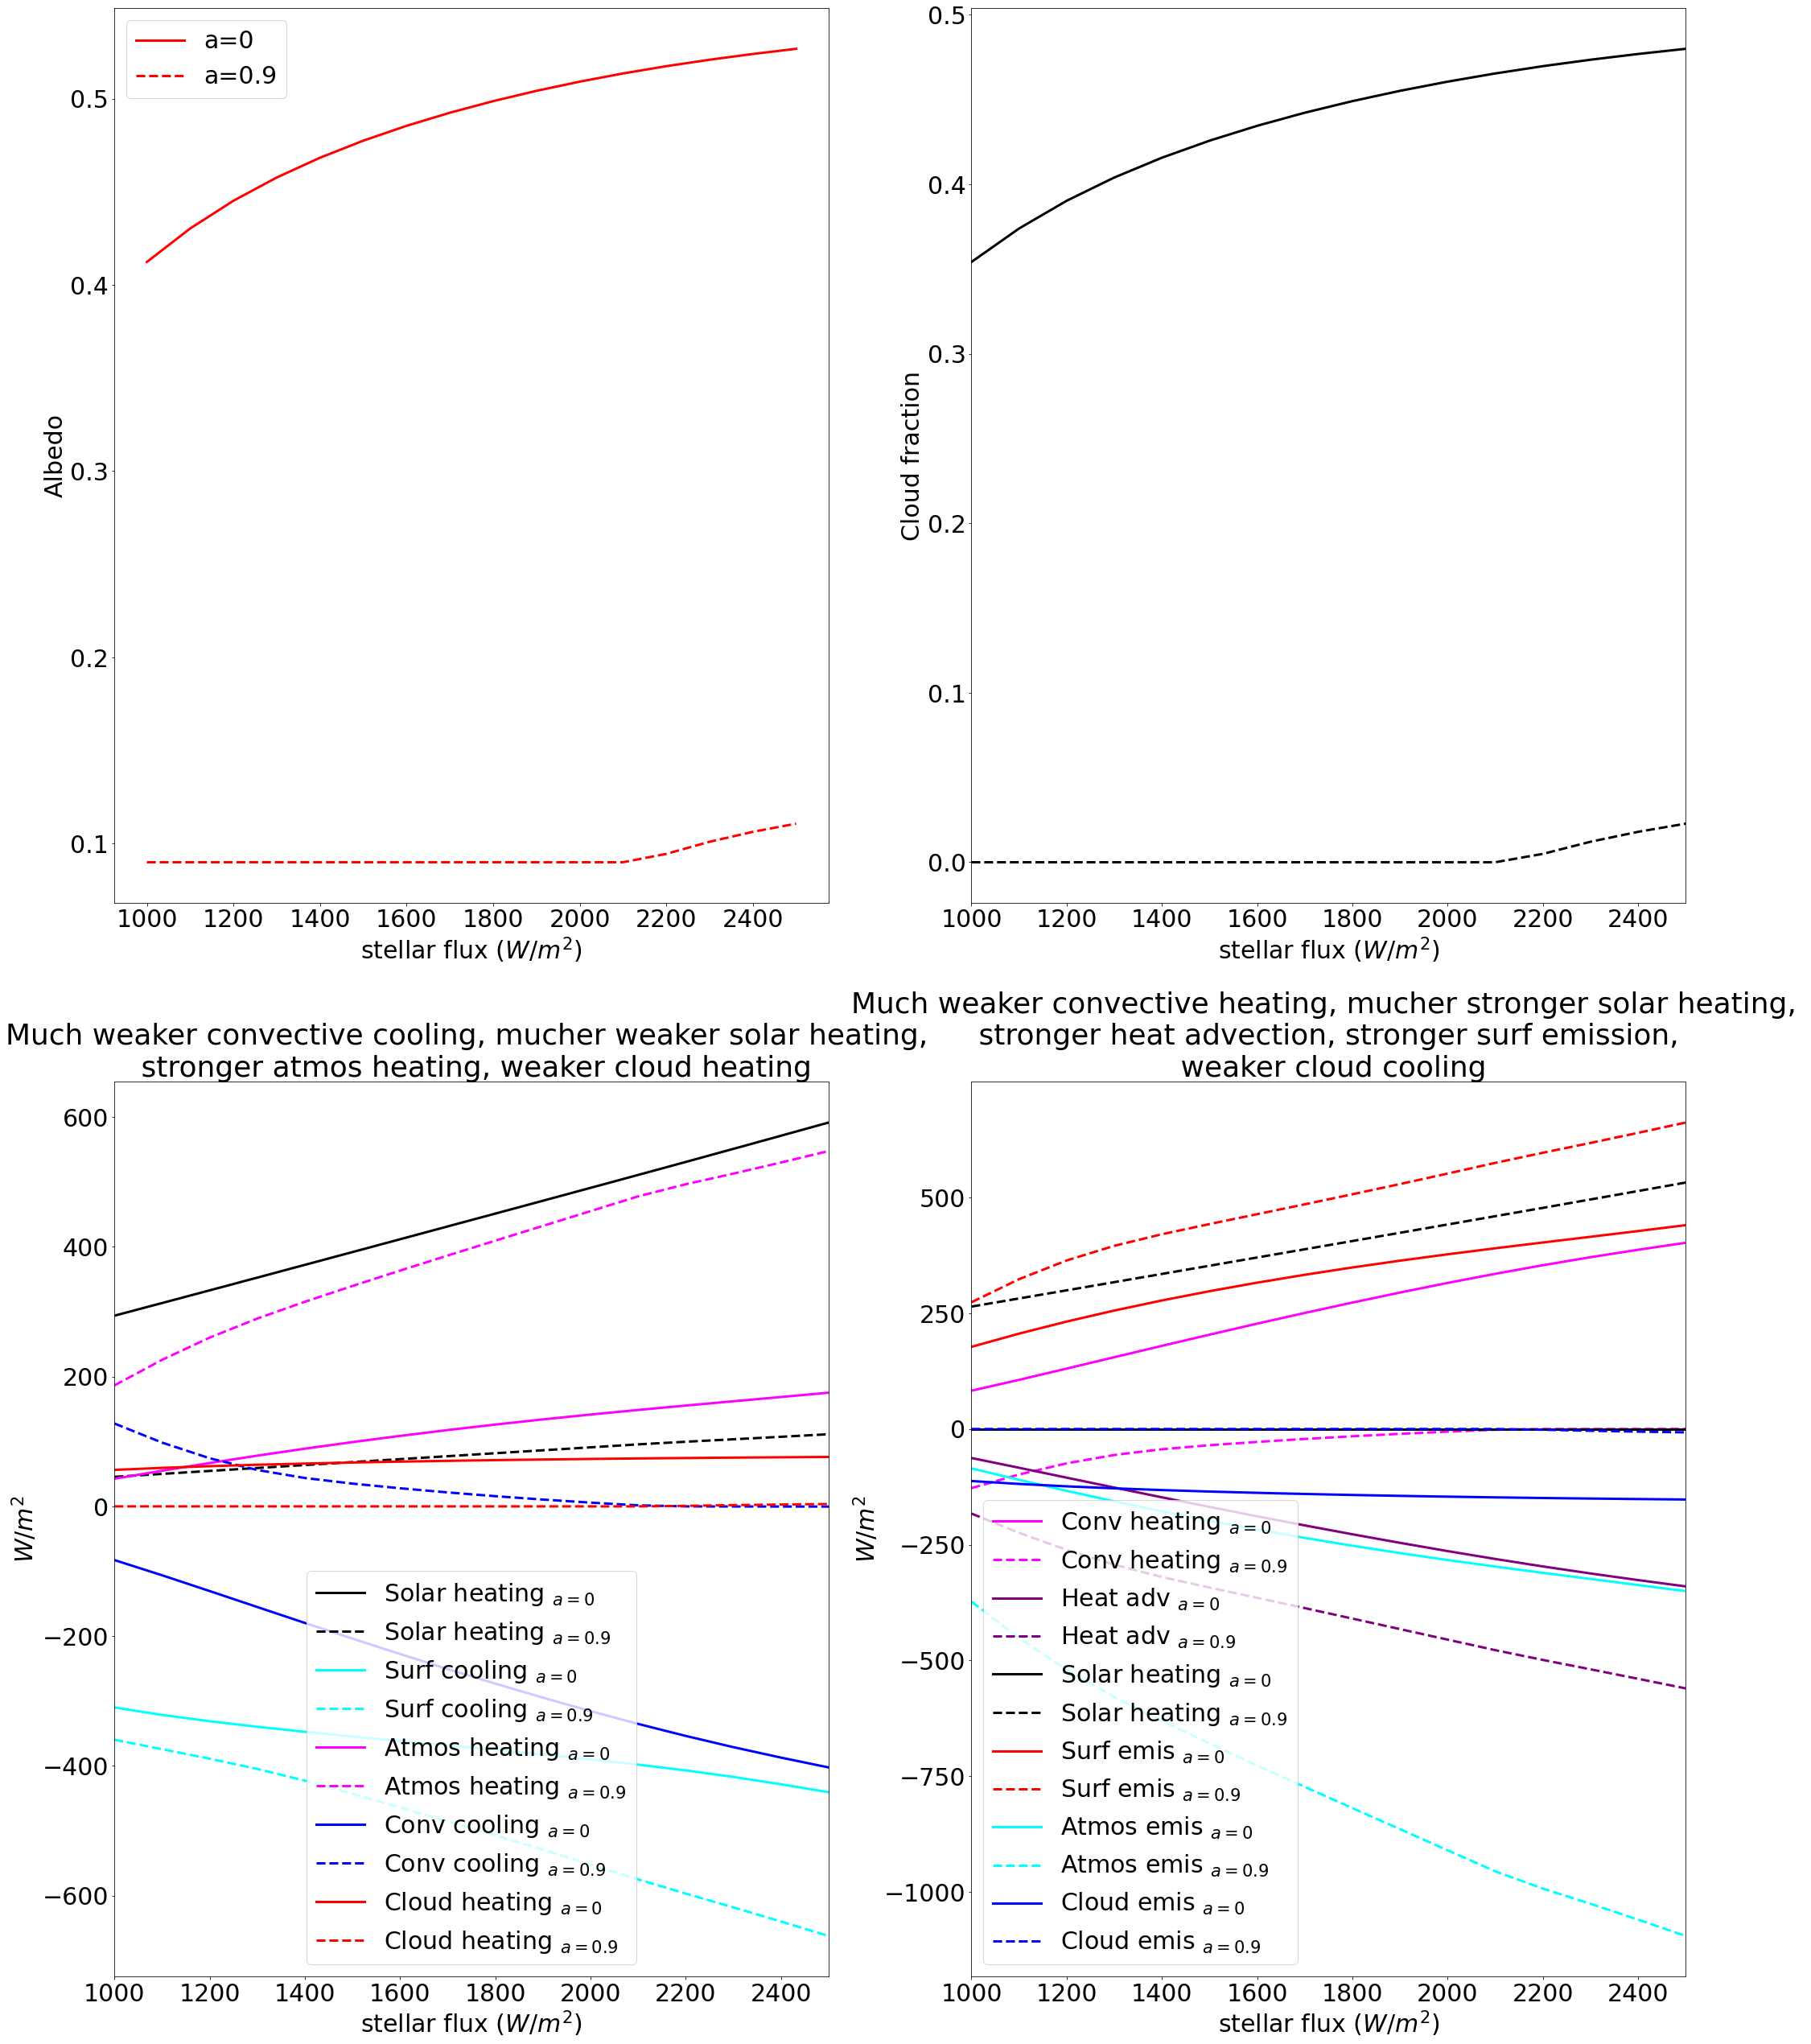

In [124]:
def plot_test(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    sigma = 5.67e-8
    Tc = 230
    a = 0.9
    
    fig, ax = plt.subplots(2, 2, figsize=(35,45)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, alpha_p_arr, '-', color = 'red',linewidth=3, label = "a=0")
    ax[0,0].plot(so, alpha_p_brr, '--', color = 'red', linewidth=3, label = "a=0.9")
    ax[0,0].set_ylabel("Albedo")
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
    # Dayside emmisivity
    ax[0,1].plot(so, fc_arr,'-', color = 'black',linewidth=3, label = r'$\epsilon_{2, a=0}$')
    ax[0,1].plot(so, fc_brr,'--', color = 'black',linewidth=3, label = r'$\epsilon_{2, a=0.9}$')
    ax[0,1].set_xlim([1000, 2500])
    ax[0,1].set_ylabel("Cloud fraction")
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    
    # Dayside energy budgets
    ax[1,0].plot(so, so/2*(1-0)*(1-alpha_p_arr),'-', color = 'black',linewidth=3, label = r'Solar heating $_{a=0}$')
    ax[1,0].plot(so, so/2*(1-a)*(1-alpha_p_brr),'--', color = 'black',linewidth=3, label = r'Solar heating $_{a=0.9}$')
    ax[1,0].plot(so, -sigma*T1_arr**4,'-', color = 'cyan',linewidth=3, label = r'Surf cooling $_{a=0}$')
    ax[1,0].plot(so, -sigma*T1_brr**4,'--', color = 'cyan',linewidth=3, label = r'Surf cooling $_{a=0.9}$')
    ax[1,0].plot(so, (1-fc_arr)*Flux2_arr,'-', color = 'magenta',linewidth=3, label = r'Atmos heating $_{a=0}$')
    ax[1,0].plot(so, (1-fc_brr)*Flux2_brr,'--', color = 'magenta',linewidth=3, label = r'Atmos heating $_{a=0.9}$')
    ax[1,0].plot(so, -Fc_arr,'-', color = 'blue',linewidth=3, label = r'Conv cooling $_{a=0}$')
    ax[1,0].plot(so, -Fc_brr,'--', color = 'blue',linewidth=3, label = r'Conv cooling $_{a=0.9}$')
    ax[1,0].plot(so, fc_arr*sigma*Tc**4,'-', color = 'red',linewidth=3, label = r'Cloud heating $_{a=0}$')
    ax[1,0].plot(so, fc_brr*sigma*Tc**4,'--', color = 'red',linewidth=3, label = r'Cloud heating $_{a=0.9}$')  
    
#     ax[1,0].plot(so, so/2*(1-0)*(1-alpha_p_arr) + fc_arr*sigma*Tc**4 - sigma*T1_arr**4 + (1-fc_arr)*Flux2_arr - Fc_arr,'-', color = 'black', \
#                  linewidth=3, label = r'Trend$_{a=0}$')
#     ax[1,0].plot(so, so/2*(1-a)*(1-alpha_p_brr) + fc_brr*sigma*Tc**4 - sigma*T1_brr**4 + (1-fc_brr)*Flux2_brr - Fc_brr,'--', color = 'black', \
#                  linewidth=3, label = r'Trend$_{a=0.5}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'$W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    ax[1,0].set_title("Much weaker convective cooling, mucher weaker solar heating, \n stronger atmos heating, weaker cloud heating")
    
    # Nightside energy budgets
    ax[1,1].plot(so, Fc_arr,'-', color = 'magenta',linewidth=3, label = r'Conv heating $_{a=0}$')
    ax[1,1].plot(so, Fc_brr,'--', color = 'magenta',linewidth=3, label = r'Conv heating $_{a=0.9}$')
    ax[1,1].plot(so, -Fa_arr,'-', color = 'purple',linewidth=3, label = r'Heat adv $_{a=0}$')
    ax[1,1].plot(so, -Fa_brr,'--', color = 'purple',linewidth=3, label = r'Heat adv $_{a=0.9}$')
    ax[1,1].plot(so, so/2*(1-1)*(1-alpha_p_arr),'-', color = 'black',linewidth=3, label = r'Solar heating $_{a=0}$')
    ax[1,1].plot(so, so/2*a*(1-alpha_p_arr),'--', color = 'black',linewidth=3, label = r'Solar heating $_{a=0.9}$')
    ax[1,1].plot(so, ((1-fc_arr)*epsilon_2_arr+fc_arr)*sigma*T1_arr**4,'-', \
                 color = 'red',linewidth=3, label = r'Surf emis $_{a=0}$')
    ax[1,1].plot(so, ((1-fc_brr)*epsilon_2_brr+fc_brr)*sigma*T1_brr**4,'--', \
                 color = 'red',linewidth=3, label = r'Surf emis $_{a=0.9}$')
    ax[1,1].plot(so, -2*(1-fc_arr)*epsilon_2_arr*sigma*T2_arr**4,'-', color = 'cyan',linewidth=3, label = r'Atmos emis $_{a=0}$')
    ax[1,1].plot(so, -2*(1-fc_brr)*epsilon_2_brr*sigma*T2_brr**4,'--', color = 'cyan',linewidth=3, label = r'Atmos emis $_{a=0.9}$')
    ax[1,1].plot(so, -2*fc_arr*sigma*Tc**4,'-', color = 'blue',linewidth=3, label = r'Cloud emis $_{a=0}$')
    ax[1,1].plot(so, -2*fc_brr*sigma*Tc**4,'--', color = 'blue',linewidth=3, label = r'Cloud emis $_{a=0.9}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    ax[1,1].set_title("Much weaker convective heating, mucher stronger solar heating, \n stronger heat advection, stronger surf emission, \n weaker cloud cooling")
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_test(so)

Text(0.5, 1.0, 'my idealized SW/LW ratio')

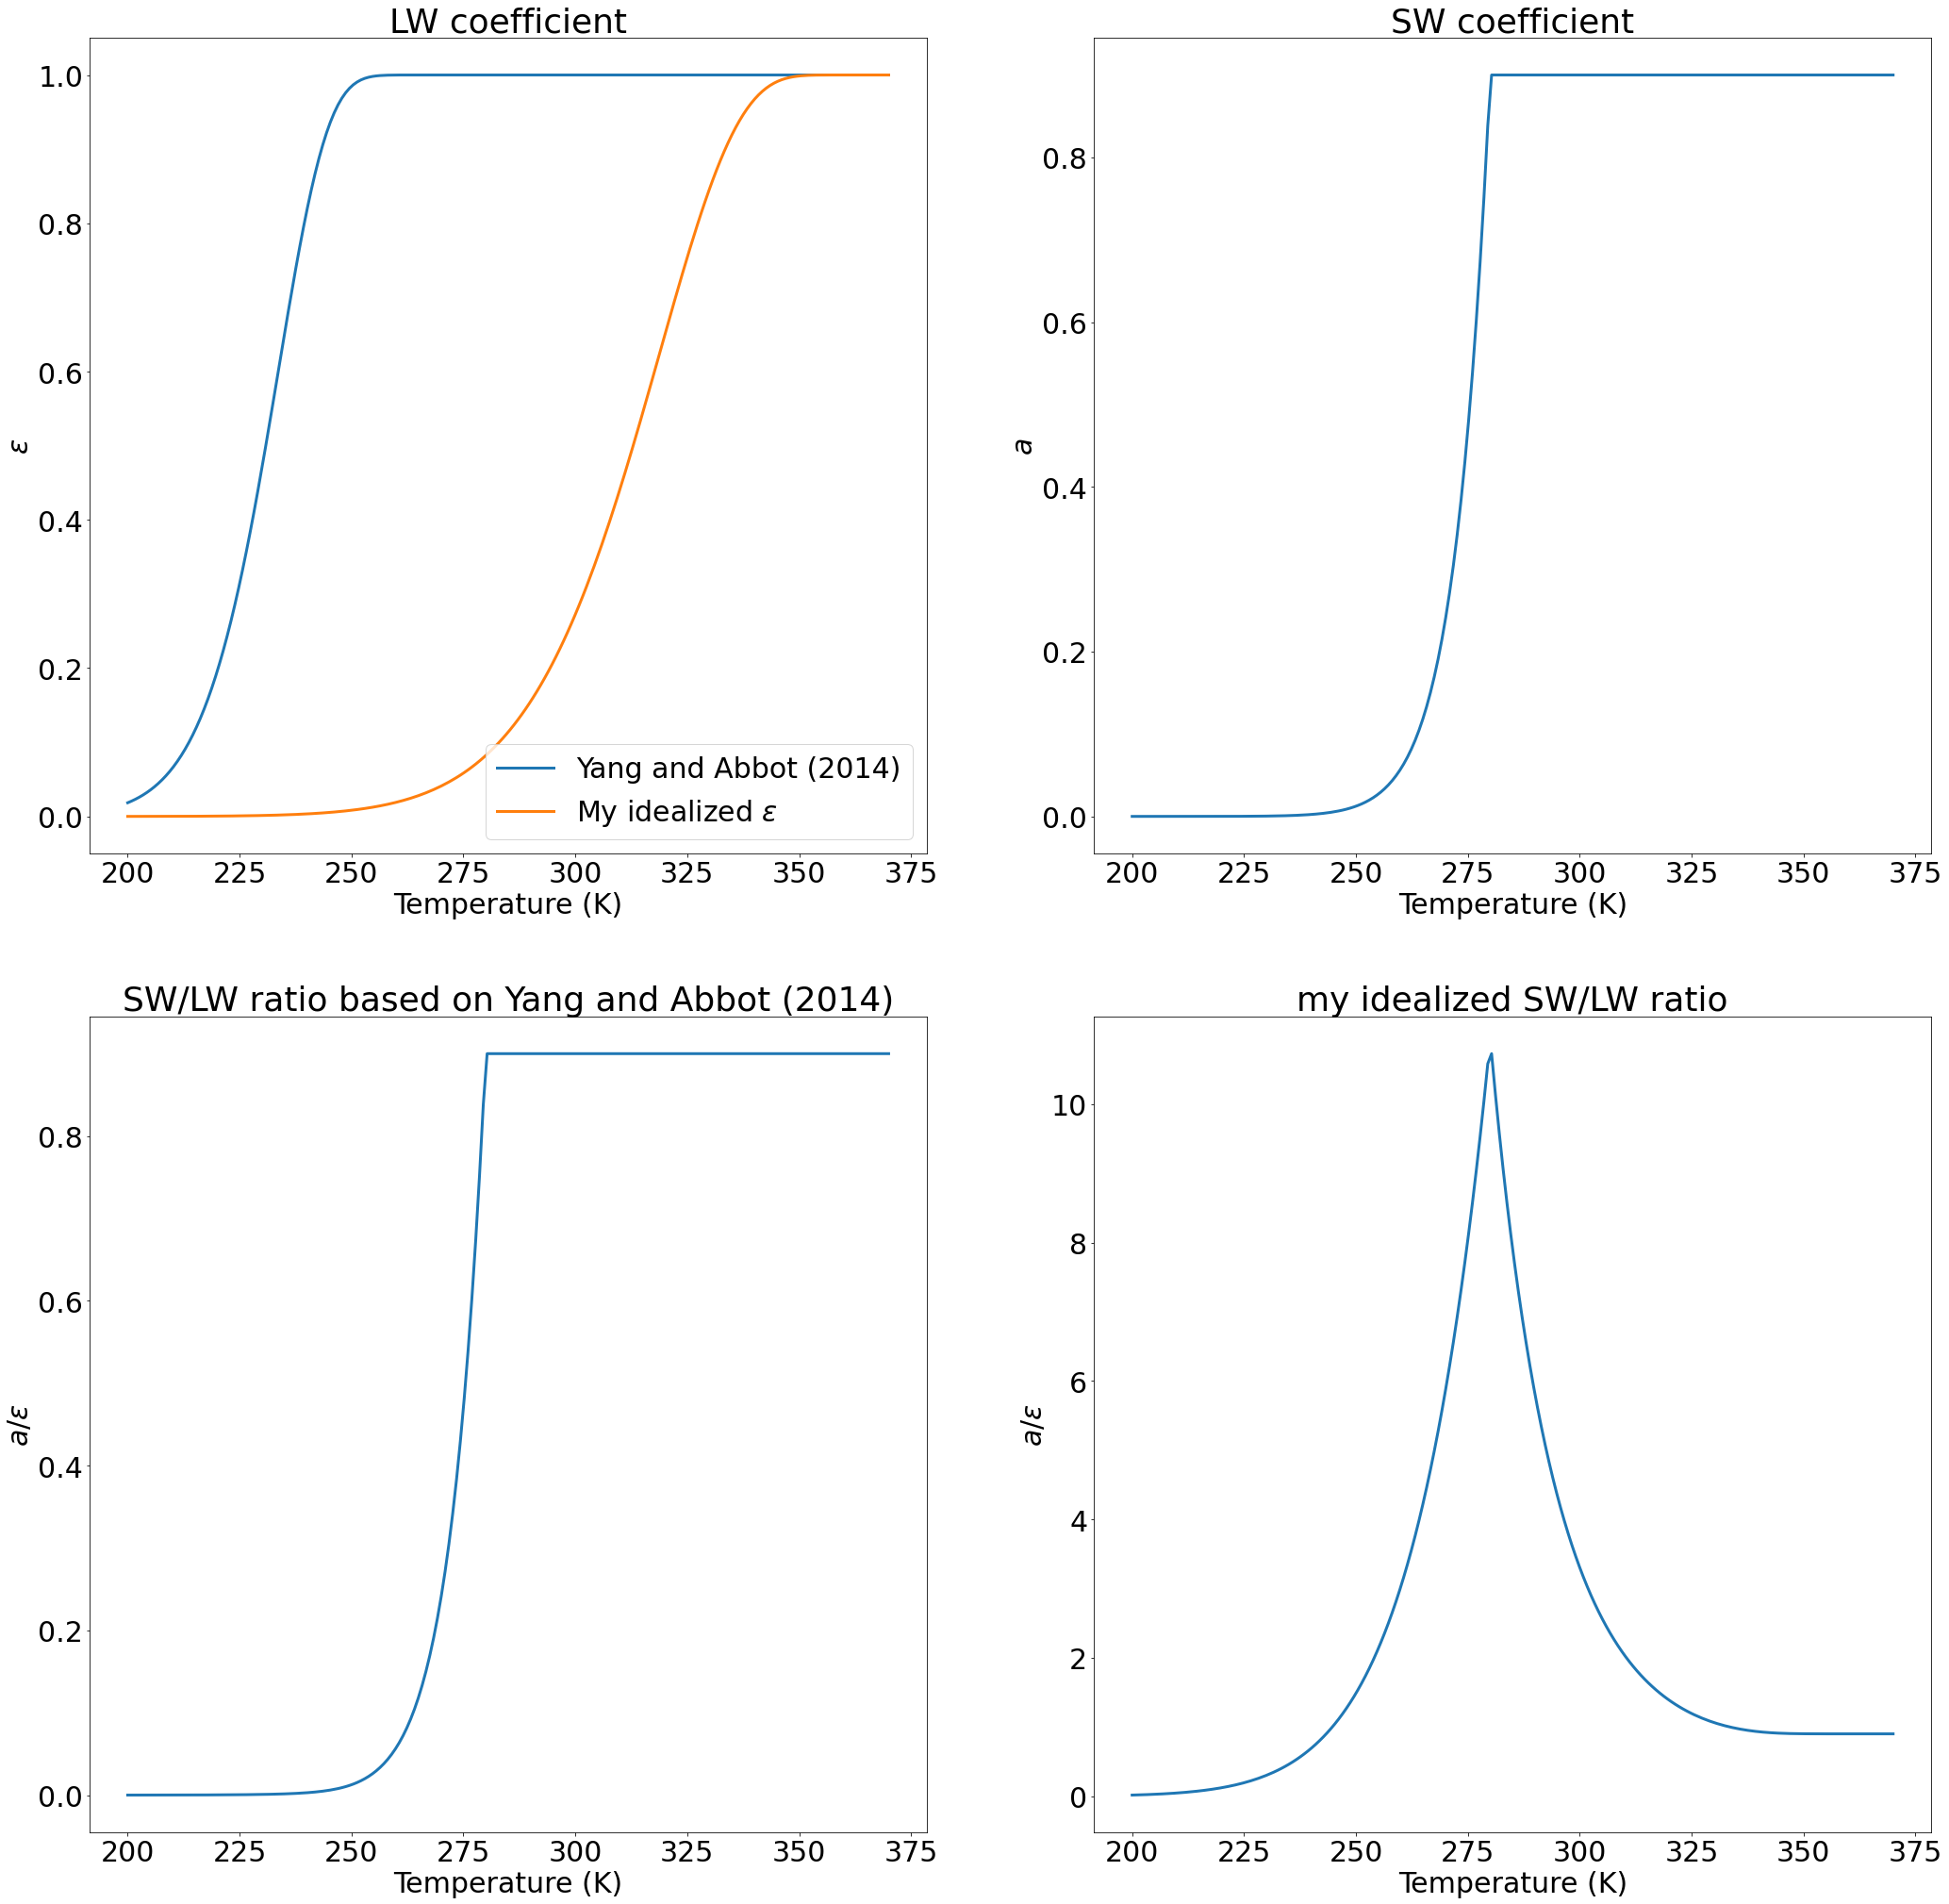

In [11]:
def tau(T,Tft):
    tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
    return tau


def epsilon_orig(T2):
    es0 = 611.2
    M = 0.018
    To = 273.15
    mm_dry = 0.028
    R_star = 8.3145
    mass_ratio = M/mm_dry
    L = 2.501e6 # J/kg #latent heat of vaporization
    Pc = 6e4
    RH2 = 0.8
#     k2 = 1e4
    k2 = 5000
    
    es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
    ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
    w_2 = RH2 * ws_2
    q2 = w_2/(1+w_2)
    epsilon_2 = 1 - np.exp(-k2*q2)
    return epsilon_2

def epsilon_orig_ver2(T2):
    es0 = 611.2
    M = 0.018
    To = 273.15
    mm_dry = 0.028
    R_star = 8.3145
    mass_ratio = M/mm_dry
    L = 2.501e6 # J/kg #latent heat of vaporization
    Pc = 6e4
    RH2 = 0.8
#     k2 = 1e4
    k2 = 10
    
    es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
    ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
    w_2 = RH2 * ws_2
    q2 = w_2/(1+w_2)
    epsilon_2 = 1 - np.exp(-k2*q2)
    return epsilon_2  

# def a(T):
#     T_ref = 280   # Temperature of full absorption limit 
#     a_ref = 0.9      # Max water vapor absorption to sunlight
#     ka = 10e3      # exponetional factor (like CC relation)
#     if T <= T_ref:
#         a_2 = a_ref*np.exp(-ka*(1/T - 1/T_ref))
#     else:
#         a_2 = a_ref
#     return a_2

def water_vapor_absorption(temperature):
    temperature_ref = 280   # Temperature of full absorption limit 
    absorption_ref = 0.9      # Max water vapor absorption to sunlight
    ka = 1e4      # exponential factor (like CC relation)
    a = np.zeros_like(temperature)
    mask = temperature <= temperature_ref
    a[mask] = absorption_ref * np.exp(-ka * (1 / temperature[mask] - 1 / temperature_ref))
    a[~mask] = absorption_ref
    return a

def IR_absorption(temperature):
    temperature_ref = 330   # Temperature of full absorption limit 
    absorption_ref = 0.9      # Max water vapor absorption to IR
    ka = 10000      # exponential factor (like CC relation)
    a = np.zeros_like(temperature)
    mask = temperature <= temperature_ref
    a[mask] = absorption_ref * np.exp(-ka * (1 / temperature[mask] - 1 / temperature_ref))
    a[~mask] = absorption_ref
    return a

sigma = 5.67e-8

T = np.linspace(200,370,200)
epsilon_2_tau = 1/(1+tau(T,273))
epsilon_2_org = epsilon_orig(T)
a_2 = water_vapor_absorption(T)
# epsilon_2 = IR_absorption(T)
epsilon_2 = epsilon_orig_ver2(T)

Lr_atm_gh = epsilon_2_tau*sigma*T**4
Lr_atm = epsilon_2*sigma*T**4

plt.rc('font', size = 30) 
fig, ax = plt.subplots(2, 2, figsize=(35,35)) 
# plt.rcParams['figure.constrained_layout.use']=False
# fig = plt.figure(figsize =(6,6))
# plt.style.use('ggplot')
#plt.style.use('default')

# plt.plot(T, Lr_atm, label = r'$\epsilon = 1 - e^{k_2 q_2}$' )
# plt.plot(T, Lr_atm_gh, label = r'$ \epsilon = \frac{1}{1+\tau}$' )
# plt.legend(loc = 'best',fontsize=16, frameon = False)
# plt.ylabel(r'$\epsilon \sigma T^4 (W/m^2)$', fontsize = 18)
ax[0,0].plot(T, epsilon_2_org ,linewidth=3,label = r'Yang and Abbot (2014)')
ax[0,0].plot(T, epsilon_2,linewidth=3, label = r'My idealized $\epsilon$')
ax[0,0].set_ylabel(r'$\epsilon$')
ax[0,0].set_xlabel('Temperature (K)')
ax[0,0].legend(loc = 'best')
ax[0,0].set_title('LW coefficient')

ax[0,1].plot(T, a_2,linewidth=3)
ax[0,1].set_ylabel(r'$a$')
ax[0,1].set_xlabel('Temperature (K)')
ax[0,1].set_title('SW coefficient')

ax[1,0].plot(T, a_2/epsilon_2_org,linewidth=3)
ax[1,0].set_ylabel(r'$a/\epsilon$')
ax[1,0].set_xlabel('Temperature (K)')
ax[1,0].set_title('SW/LW ratio based on Yang and Abbot (2014)')

ax[1,1].plot(T, a_2/epsilon_2,linewidth=3)
ax[1,1].set_ylabel(r'$a/\epsilon$')
ax[1,1].set_xlabel('Temperature (K)')
ax[1,1].set_title('my idealized SW/LW ratio')